In [3]:
cd "/suphys/aloe8475"


/suphys/aloe8475


In [4]:
cd "Documents/edamame"

/import/silo2/aloe8475/Documents/edamame


In [5]:
from scipy.io import loadmat, savemat
from scipy.stats import kurtosis
import math 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import networkx as nx
from edamame import *
from tqdm import tqdm_notebook
import os
import nct
import bct
import pandas as pd
from collections import Counter

#warnings.filterwarnings('ignore')

In [6]:
from scipy.stats import gamma
from scipy.stats import expon
from scipy.stats import lognorm
from scipy.stats import powerlaw
from scipy.stats import norm
from scipy.stats import weibull_min

from scipy.optimize import curve_fit


In [7]:
import pickle 
import _pickle as cPickle
import gzip
def compressed_pickle(obj, filename,protocol=-1):
    with gzip.open(filename, 'wb') as f:
        cPickle.dump(obj, f, protocol)
def decompress_pickle(file):
    with gzip.open(file, 'rb') as f:
        loaded_object = cPickle.load(f)
        return loaded_object

In [6]:
name='/import/silo2/aloe8475/Documents/CODE/Analysis/Functional Connectivity/Functional Tasks/networks_LinearTransformation.pkl'
print('Loading ASN Networks')
file = open(name, 'rb')
#     [ASN300,cluster1,cluster2,cluster3,time_index,nodesList] = pickle.load(file)
#     [ASN300,cluster1,cluster2,cluster3] = pickle.load(file)
[ASN300] = pickle.load(file)

Loading ASN Networks


In [9]:
cd "/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/"

/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity


In [11]:
temp=loadmat('Degree.mat')
degree=temp['degree'][0]
pcoeff=temp['pcoeff'][0]
maxIdx=temp['maxIdx'][0]
minIdx=temp['minIdx'][0]
mz=temp['mz'][0]
centrality=temp['centality'][0]

In [12]:
# SORT 50 x 50 / 300 x 300 BY ACCURACY:
asn_acc=[]
asn_mod=[]
asn_avgDeg=[]
for i in range(len(ASN300)):
    for j in range(len(ASN300[i])):
        deg=np.mean([val for (node, val) in ASN300[i][j]['G'].degree()])
        asn_acc.append(np.nanmax(ASN300[i][j]['Accuracy']['Linear Transformation']))
        asn_mod.append(np.nanmax(ASN300[i][j]['Graph Theory']['Modularity Score']))
        asn_avgDeg.append(deg)
        
acc_sorted=np.sort(asn_acc)
acc_idx=np.argsort(asn_acc)

accIDX=[]        
for i in range(len(acc_idx)):
    if acc_idx[i] >= 100: 
        accIDX.append([int(float(acc_idx[i])/10),list(map(int, str(acc_idx[i])))[-1]])
    elif acc_idx[i] <10: 
        accIDX.append([0, list(map(int, str(acc_idx[i])))[-1]])
    else:
        accIDX.append(list(map(int, str(acc_idx[i]))))

In [15]:
#Sort Degree by accuracy^
degreeData=[]
for idx in acc_idx:
    degreeData.append(degree[idx])

In [16]:
#Sort PCoeff by accuracy^
pcoeffData=[]
for idx in acc_idx:
    pcoeffData.append(pcoeff[idx])

In [17]:
#Sort MZ by accuracy^
mzData=[]
for idx in acc_idx:
    mzData.append(mz[idx])

In [18]:
#Sort Centrality by accuracy^
bcData=[]
for idx in acc_idx:
    bcData.append(centrality[idx])

In [8]:
def scaleData(pdf,count):
    pdf = pdf/pdf.max()
    pdf = pdf*count.max()
    return pdf

## Degree

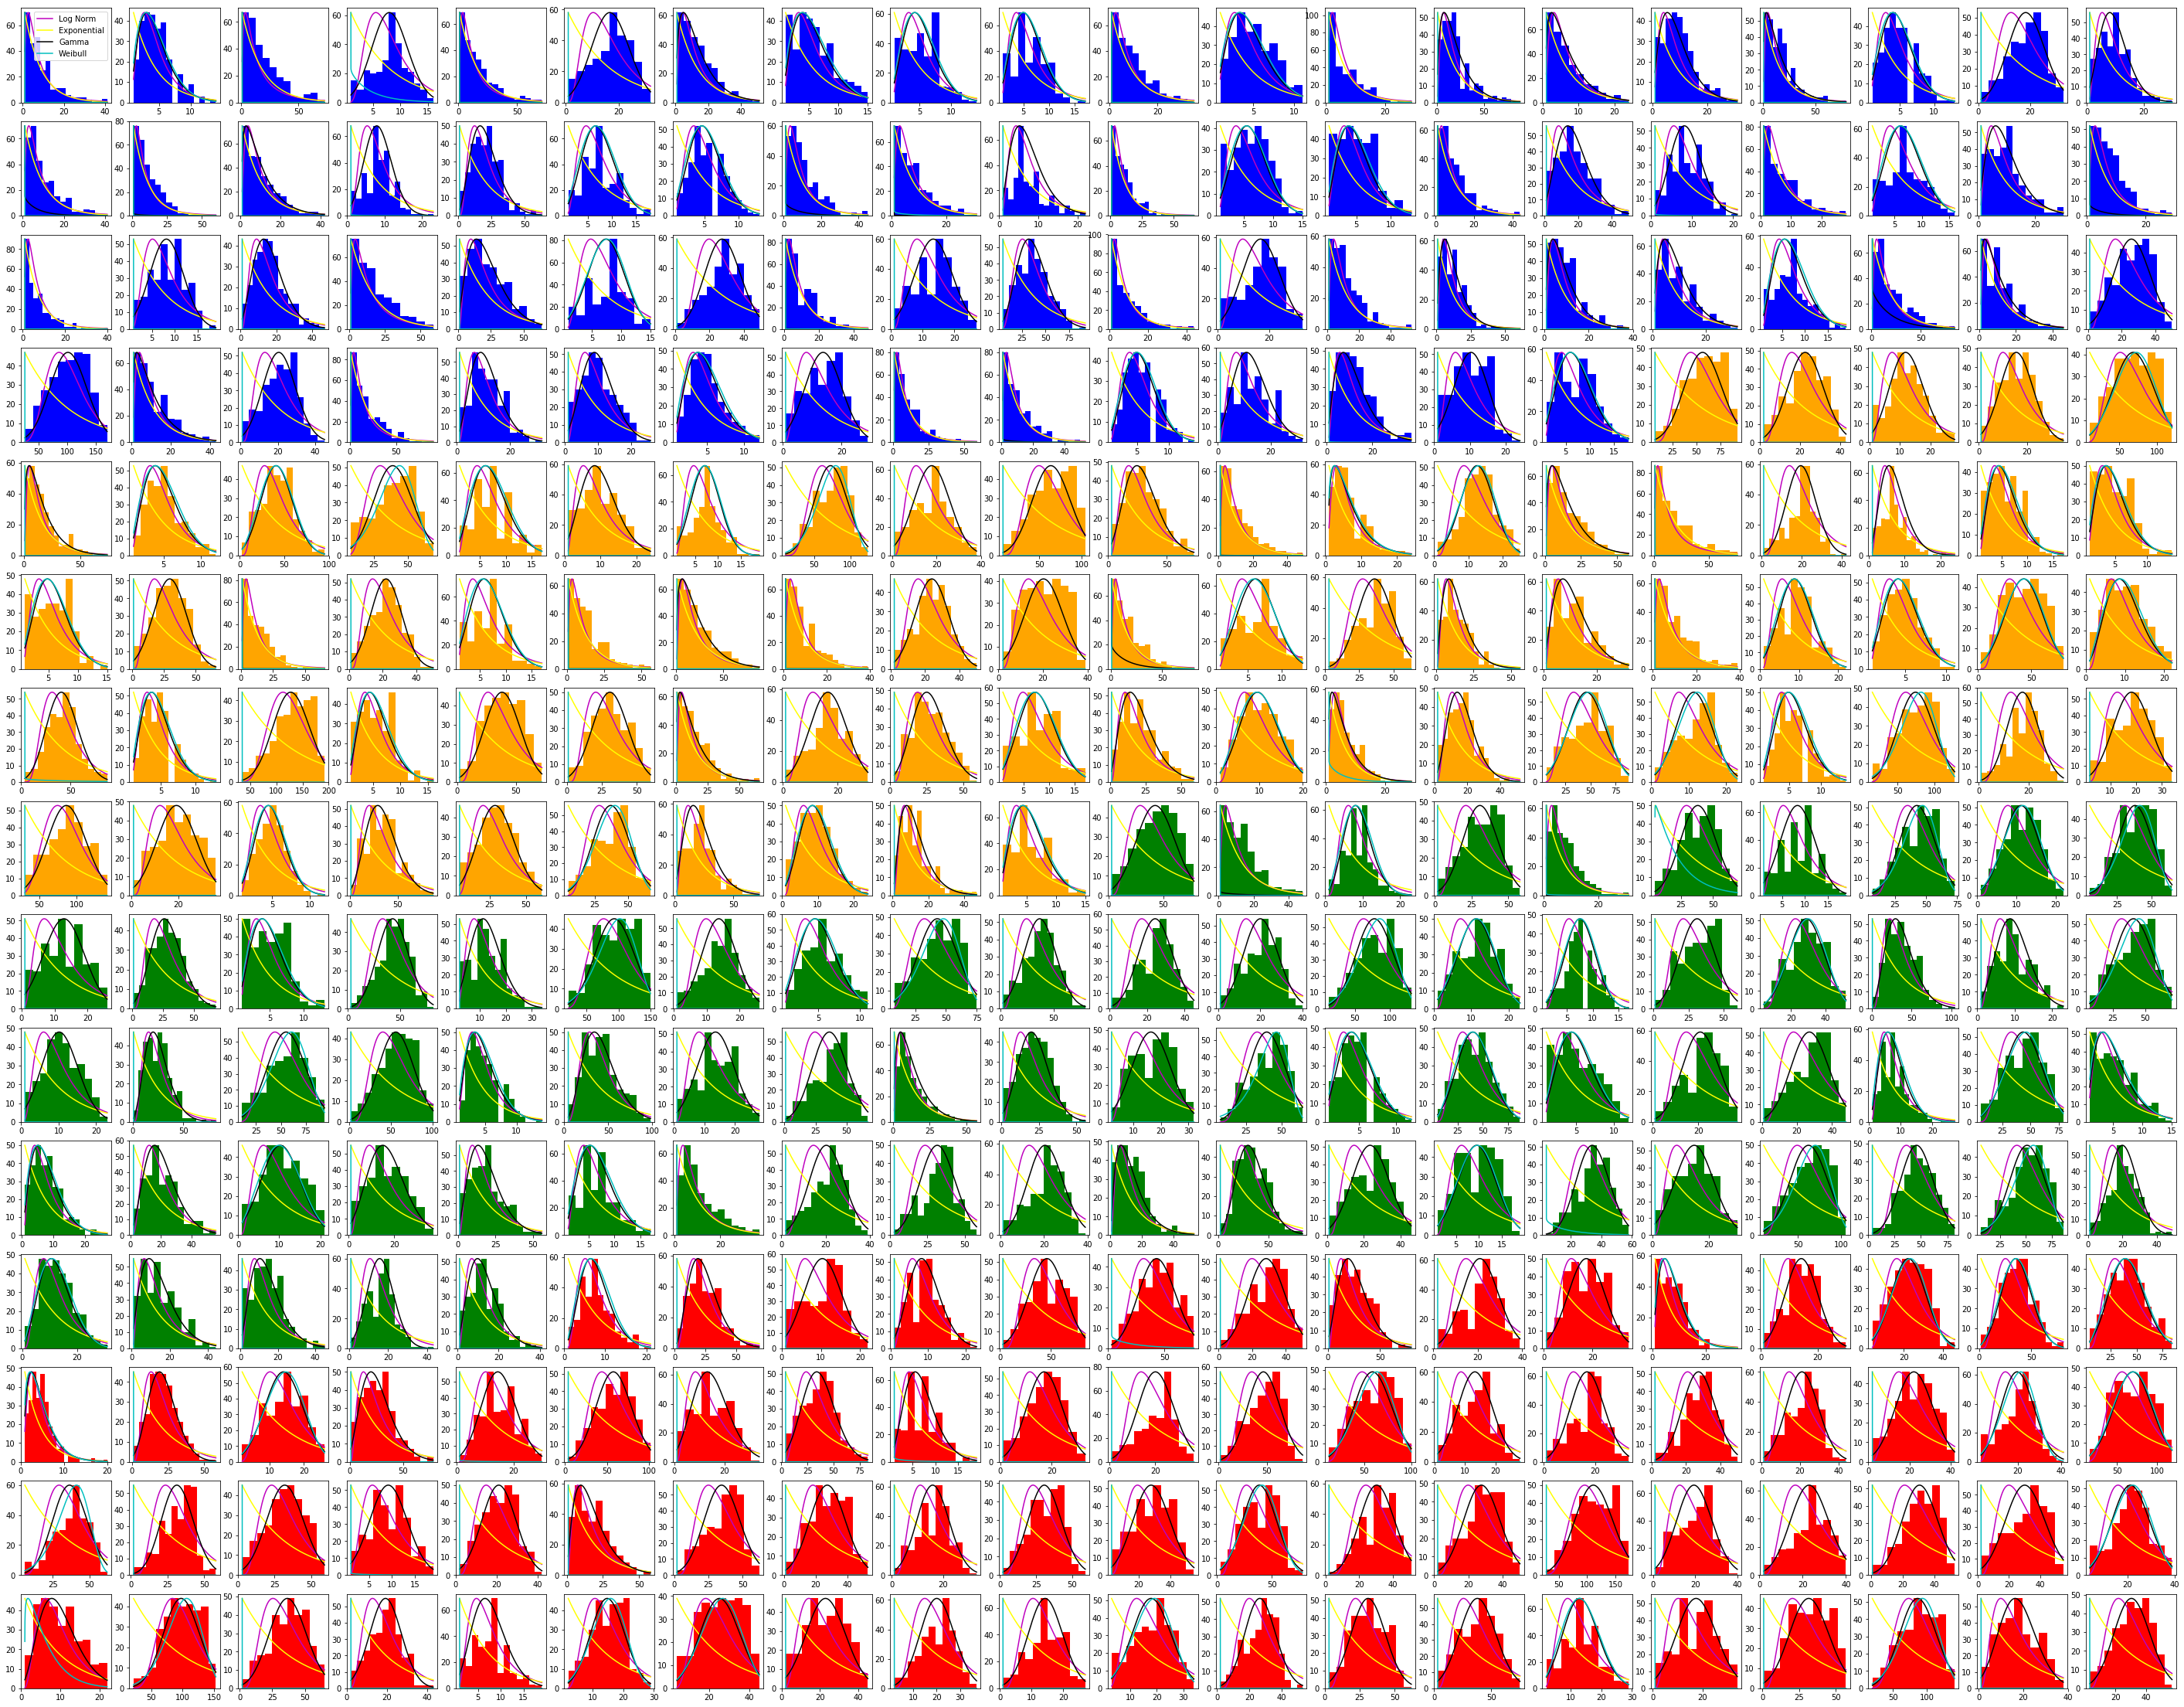

In [20]:
winner=[]
fig=plt.figure(figsize=(50,40))
ax=[None]*len(degreeData)
fitVals=[None]*len(degreeData)
bicVals=[None]*len(degreeData)

for i in tqdm(range(len(degreeData))):
    ax[i]=fig.add_subplot(15,20,i+1)
    r=degreeData[i]
    # Find Frequencies and Bins
    bin_heights, bin_borders = np.histogram(r, bins='auto')
    bin_widths = np.diff(bin_borders)
    bin_centers = bin_borders[:-1] + bin_widths / 2

    #Fit Values:
    LN, loc, scale = lognorm.fit(r, floc=0)
    E = expon.fit(r)
#     PL = powerlaw.fit(r)
    WB = weibull_min.fit(r)
    G = gamma.fit(r)

    #Negative Log Likelihood:
    llG = np.sum(gamma.logpdf(r, G[0], loc=G[1], scale=G[2]) ) 
    llE = np.sum(expon.logpdf(r, E[0], E[1]))
#     llPL = np.sum(powerlaw.logpdf(r, PL[0], PL[1], PL[2]) ) 
    llLM = np.sum(lognorm.logpdf(r, LN, loc=loc, scale=scale) ) 
    llWB = np.sum(weibull_min.logpdf(r, WB[0],WB[1],WB[2]) ) 

    #BIC:
    # BIC = -2 * LL + log(N) * k

    bicG = -2* llG + len(G)*np.log(len(r[0]))
    bicE = -2* llE + len(E)*np.log(len(r[0]))
#     bicPL = -2* llPL + len([llPL])*np.log(len(r[0]))
    bicLM = -2* llLM + len([LN])*np.log(len(r[0]))
    bicWB = -2* llWB + len(WB)*np.log(len(r[0]))

    #Find length of x
    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

    #Plot Histogram
    if i < 75:
        color='b'
    elif i >=75 and i < 150:
        color = 'orange'
    elif i >=150 and i < 225:
        color = 'g'
    else:
        color = 'r'
    plt.bar(bin_centers, bin_heights, width=bin_widths,color=color)

    # Probability Density Function 
    pdfLog = lognorm.pdf(x_interval_for_fit, LN, scale=scale)
    pdfExp = expon.pdf(x_interval_for_fit, *E)
#     pdfPwl = powerlaw.pdf(x_interval_for_fit,*PL)
    pdfGam = gamma.pdf(x_interval_for_fit,*G)
    pdfWB = weibull_min.pdf(x_interval_for_fit,*WB)

    #Renormalise scale:
    pdfLog=scaleData(pdfLog,bin_heights)
    pdfExp=scaleData(pdfExp,bin_heights)
#     pdfPwl=scaleData(pdfPwl,bin_heights)
    pdfGam=scaleData(pdfGam,bin_heights)
    pdfWB=scaleData(pdfWB,bin_heights)

    #Plot fit on histogram
    plt.plot(x_interval_for_fit, pdfLog, 'm',label='Log Norm')
    plt.plot(x_interval_for_fit, pdfExp, 'yellow',label='Exponential')
#     plt.plot(x_interval_for_fit, pdfPwl, 'c',label='Power Law')
    plt.plot(x_interval_for_fit, pdfGam, 'k',label='Gamma')
    plt.plot(x_interval_for_fit, pdfWB, 'c',label='Weibull')
    if i == 0:
        plt.legend(loc='best')

#     print(f'Gamma BIC: {bicG}')
#     print(f'Exponential BIC: {bicE}')
#     print(f'Power Law BIC: {bicPL}')
#     print(f'Log Normal BIC: {bicLM}')

    if bicG < bicE and bicG < bicWB and bicG < bicLM:
        winner.append('Gamma')
    elif bicE < bicG and bicE < bicWB and bicE < bicLM:
        winner.append('Exponential')
    elif bicWB < bicG and bicWB < bicE and bicWB < bicLM:
        winner.append('Weibull') 
    elif bicLM < bicG and bicLM < bicE and bicLM < bicWB:
        winner.append('Log Normal')  

    bicVals[i]={'Exponential':bicE,'Gamma':bicG,'Log Normal':bicLM,'Weibull':bicWB}
    fitVals[i]={'Exponential':E,'Gamma':G,'Log Normal':LN,'Weibull':WB}

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/All Networks Curve Fitting Histograms sorted by Accuracy.png',format='png',dpi=300)

In [23]:
maxWinners=[]
minWinners=[]
for idx in maxIdx:
    maxWinners.append(winner[idx])
    
for idx in minIdx:
    minWinners.append(winner[idx])

In [24]:
print('All Networks:')
print('Num Gamma Best Fit = ' + str(winner.count('Gamma')))
print('Num Weibull Best Fit = ' + str(winner.count('Weibull')))
print('Num Exponential Best Fit = ' + str(winner.count('Exponential')))
print('Num Log Normal Best Fit = ' + str(winner.count('Log Normal')))

print('\nMax Accuracy Networks:')
print('Num Gamma Best Fit = ' + str(maxWinners.count('Gamma')))
print('Num Weibull Best Fit = ' + str(maxWinners.count('Weibull')))
print('Num Exponential Best Fit = ' + str(maxWinners.count('Exponential')))
print('Num Log Normal Best Fit = ' + str(maxWinners.count('Log Normal')))

print('\nMin Accuracy Networks:')
print('Num Gamma Best Fit = ' + str(minWinners.count('Gamma')))
print('Num Weibull Best Fit = ' + str(minWinners.count('Weibull')))
print('Num Exponential Best Fit = ' + str(minWinners.count('Exponential')))
print('Num Log Normal Best Fit = ' + str(minWinners.count('Log Normal')))

All Networks:
Num Gamma Best Fit = 183
Num Weibull Best Fit = 115
Num Exponential Best Fit = 2
Num Log Normal Best Fit = 0

Max Accuracy Networks:
Num Gamma Best Fit = 31
Num Weibull Best Fit = 19
Num Exponential Best Fit = 0
Num Log Normal Best Fit = 0

Min Accuracy Networks:
Num Gamma Best Fit = 34
Num Weibull Best Fit = 16
Num Exponential Best Fit = 0
Num Log Normal Best Fit = 0


## PCoeff

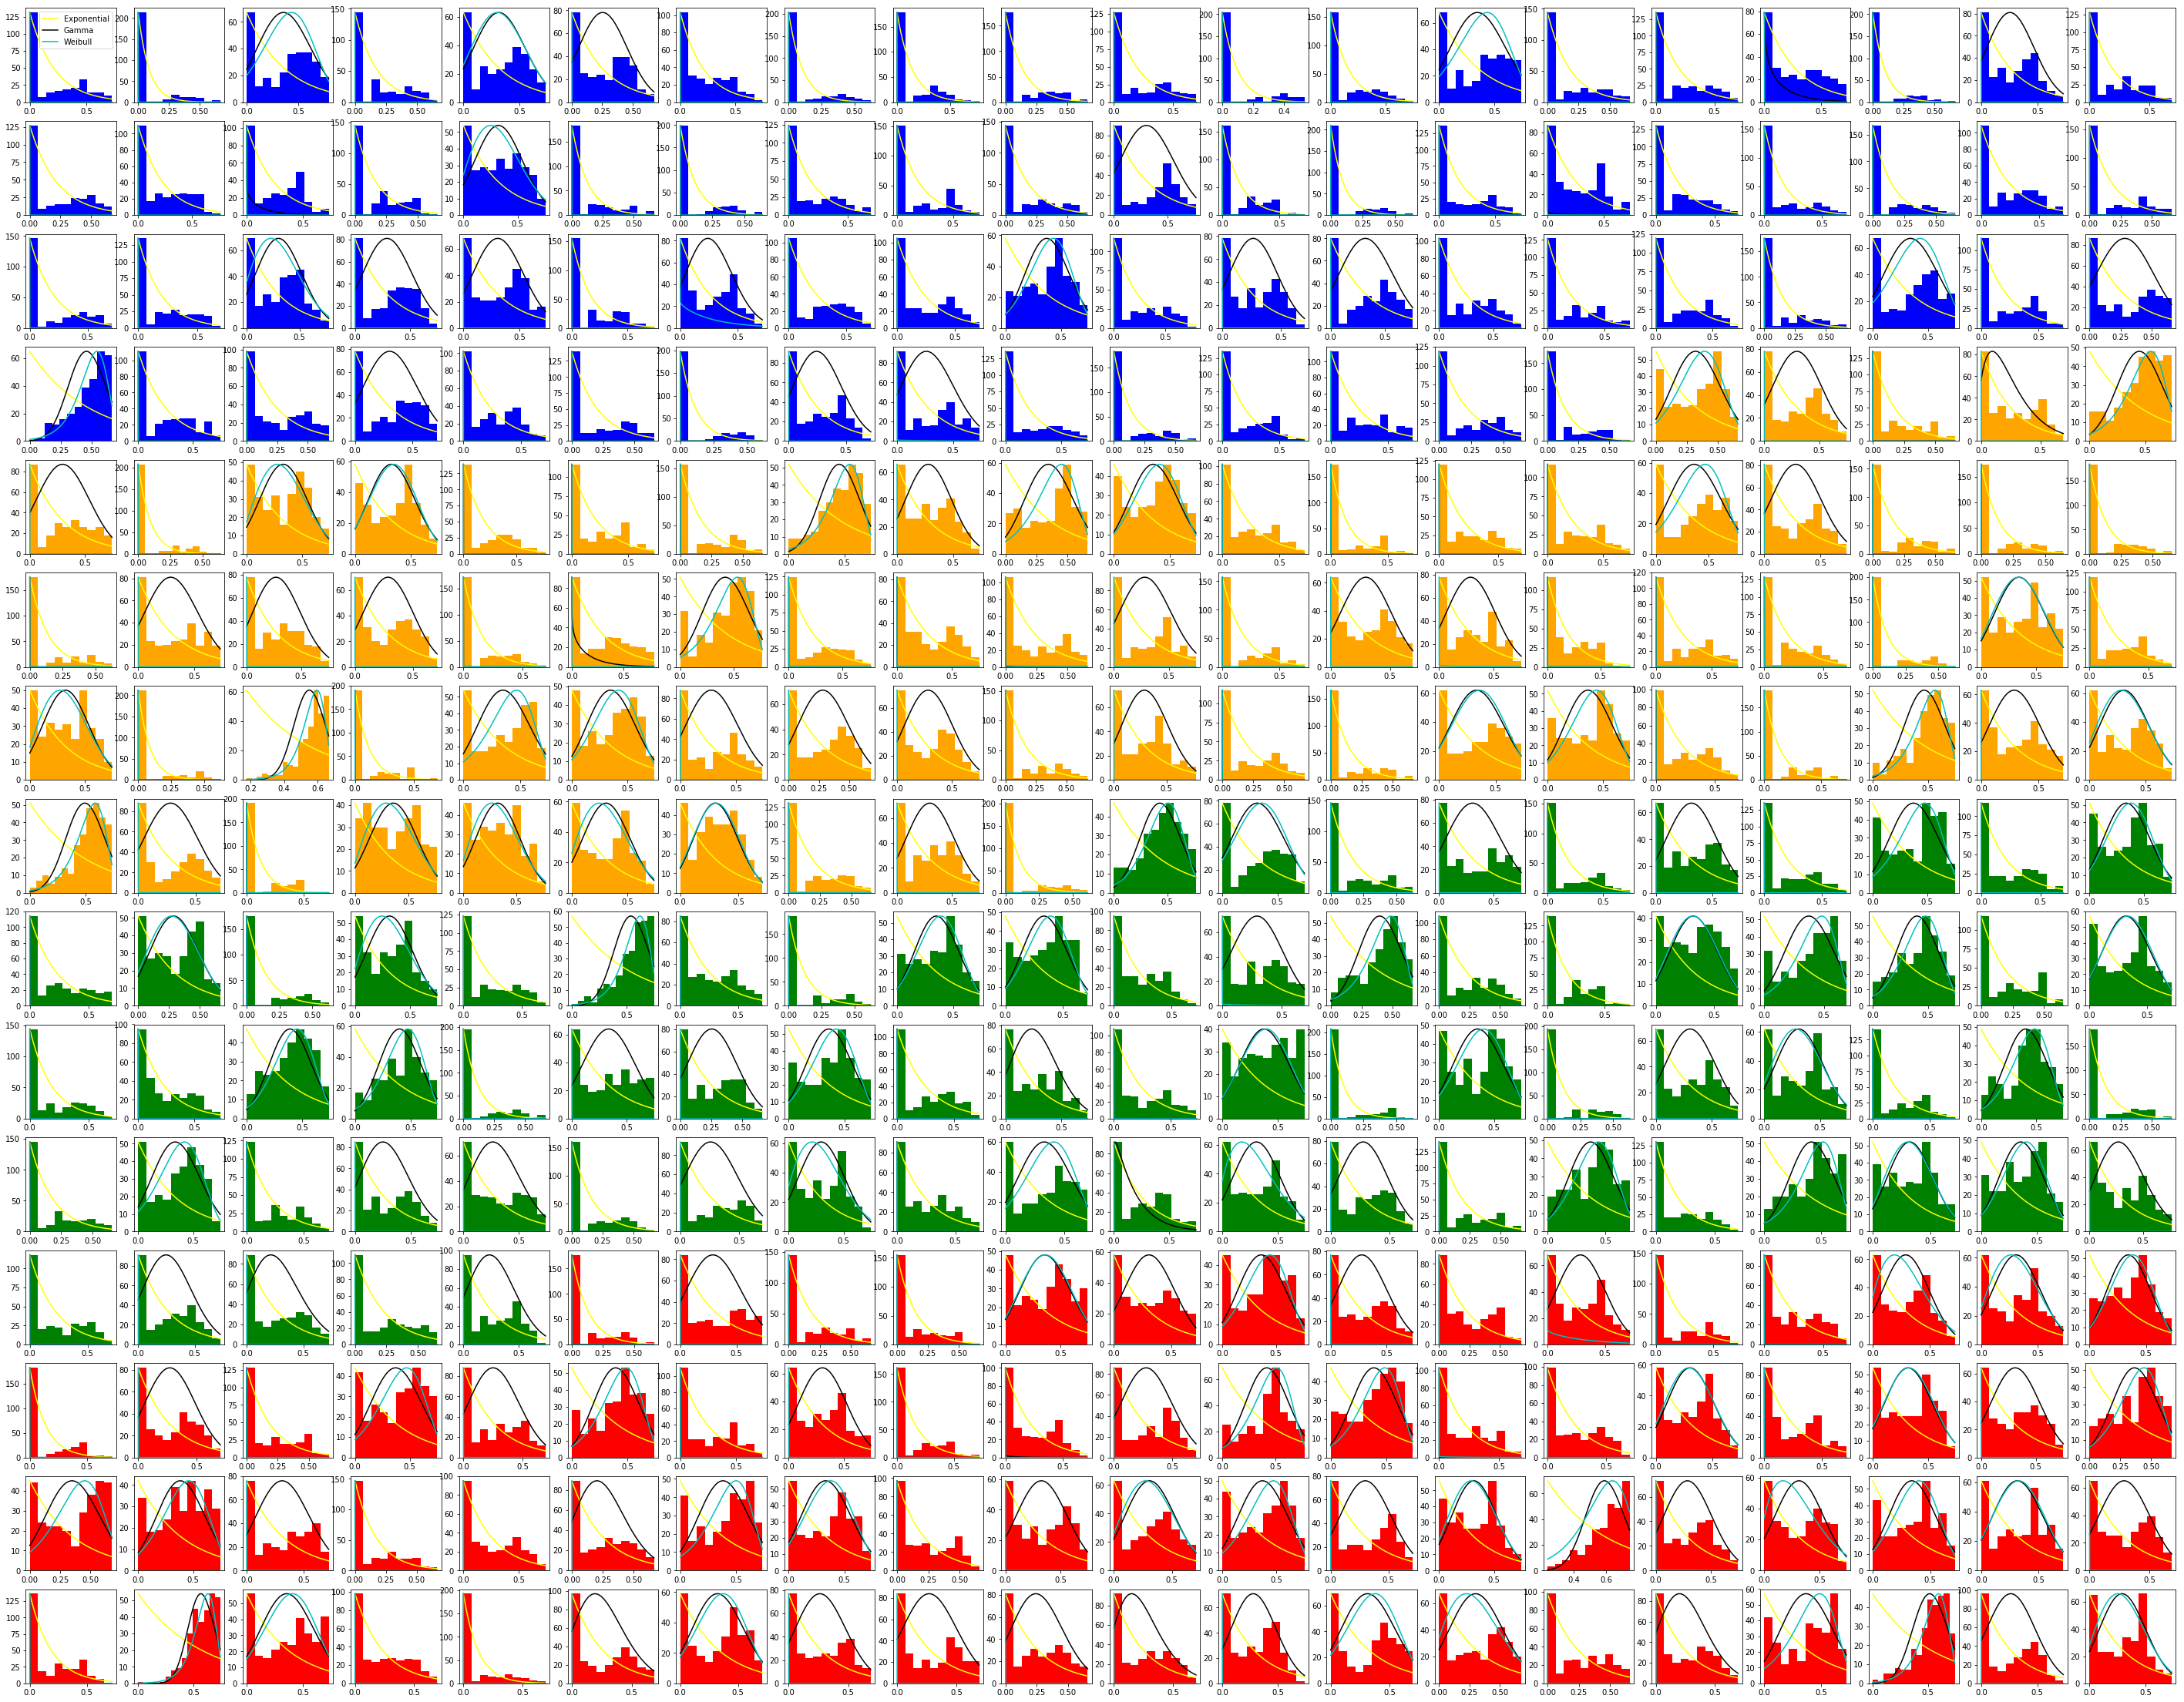

In [25]:
winnerPC=[]
fig=plt.figure(figsize=(50,40))
ax=[None]*len(pcoeffData)
fitValsPC=[None]*len(pcoeffData)
bicValsPC=[None]*len(pcoeffData)

for i in tqdm(range(len(pcoeffData))):
    ax[i]=fig.add_subplot(15,20,i+1)
    r=pcoeffData[i]
    # Find Frequencies and Bins
    bin_heights, bin_borders = np.histogram(r, bins='auto')
    bin_widths = np.diff(bin_borders)
    bin_centers = bin_borders[:-1] + bin_widths / 2

    #Fit Values:
#     LN, loc, scale = lognorm.fit(r, floc=0)
    E = expon.fit(r)
#     PL = powerlaw.fit(r)
    WB = weibull_min.fit(r)
    G = gamma.fit(r)

    #Log Likelihood:
    llG = np.sum(gamma.logpdf(r, G[0], loc=G[1], scale=G[2]) ) 
    llE = np.sum(expon.logpdf(r, E[0], E[1]))
#     llPL = np.sum(powerlaw.logpdf(r, PL[0], PL[1], PL[2]) ) 
#     llLM = np.sum(lognorm.logpdf(r, LN, loc=loc, scale=scale) ) 
    llWB = np.sum(weibull_min.logpdf(r, WB[0],WB[1],WB[2]) ) 

    #BIC:
    # BIC = -2 * LL + log(N) * k

    bicG = -2* llG + len(G)*np.log(len(r[0]))
    bicE = -2* llE + len(E)*np.log(len(r[0]))
#     bicPL = -2* llPL + len([llPL])*np.log(len(r[0]))
#     bicLM = -2* llLM + len([llLM])*np.log(len(r[0]))
    bicWB = -2* llWB + len(WB)*np.log(len(r[0]))

    #Find length of x
    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

    #Plot Histogram
    if i < 75:
        color='b'
    elif i >=75 and i < 150:
        color = 'orange'
    elif i >=150 and i < 225:
        color = 'g'
    else:
        color = 'r'
    plt.bar(bin_centers, bin_heights, width=bin_widths,color=color)

    # Probability Density Function 
#     pdfLog = lognorm.pdf(x_interval_for_fit, LN, scale=scale)
    pdfExp = expon.pdf(x_interval_for_fit, *E)
#     pdfPwl = powerlaw.pdf(x_interval_for_fit,*PL)
    pdfGam = gamma.pdf(x_interval_for_fit,*G)
    pdfWB = weibull_min.pdf(x_interval_for_fit,*WB)

    #Renormalise scale:
#     pdfLog=scaleData(pdfLog,bin_heights)
    pdfExp=scaleData(pdfExp,bin_heights)
#     pdfPwl=scaleData(pdfPwl,bin_heights)
    pdfGam=scaleData(pdfGam,bin_heights)
    pdfWB=scaleData(pdfWB,bin_heights)

    #Plot fit on histogram
#     plt.plot(x_interval_for_fit, pdfLog, 'm',label='Log Norm')
    plt.plot(x_interval_for_fit, pdfExp, 'yellow',label='Exponential')
#     plt.plot(x_interval_for_fit, pdfPwl, 'c',label='Power Law')
    plt.plot(x_interval_for_fit, pdfGam, 'k',label='Gamma')
    plt.plot(x_interval_for_fit, pdfWB, 'c',label='Weibull')
    if i == 0:
        plt.legend(loc='best')

#     print(f'Gamma BIC: {bicG}')
#     print(f'Exponential BIC: {bicE}')
#     print(f'Power Law BIC: {bicPL}')
#     print(f'Log Normal BIC: {bicLM}')

    if bicG < bicE and bicG < bicWB: #and bicG < bicLM:
        winnerPC.append('Gamma')
    elif bicE < bicG and bicE < bicWB: #and bicE < bicLM:
        winnerPC.append('Exponential')
    elif bicWB < bicG and bicWB < bicE:# and bicWB < bicLM:
        winnerPC.append('Weibull') 
#     elif bicLM < bicG and bicLM < bicE and bicLM < bicWB:
#         winner.append('Log Normal')  
        
    bicValsPC[i]={'Exponential':bicE,'Gamma':bicG,'Log Normal':bicLM,'Weibull':bicWB}
    fitValsPC[i]={'Exponential':E,'Gamma':G,'Log Normal':LN,'Weibull':WB}
    
plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/All Networks Curve Fitting Histograms PCOEFF sorted by Accuracy.png',format='png',dpi=300)

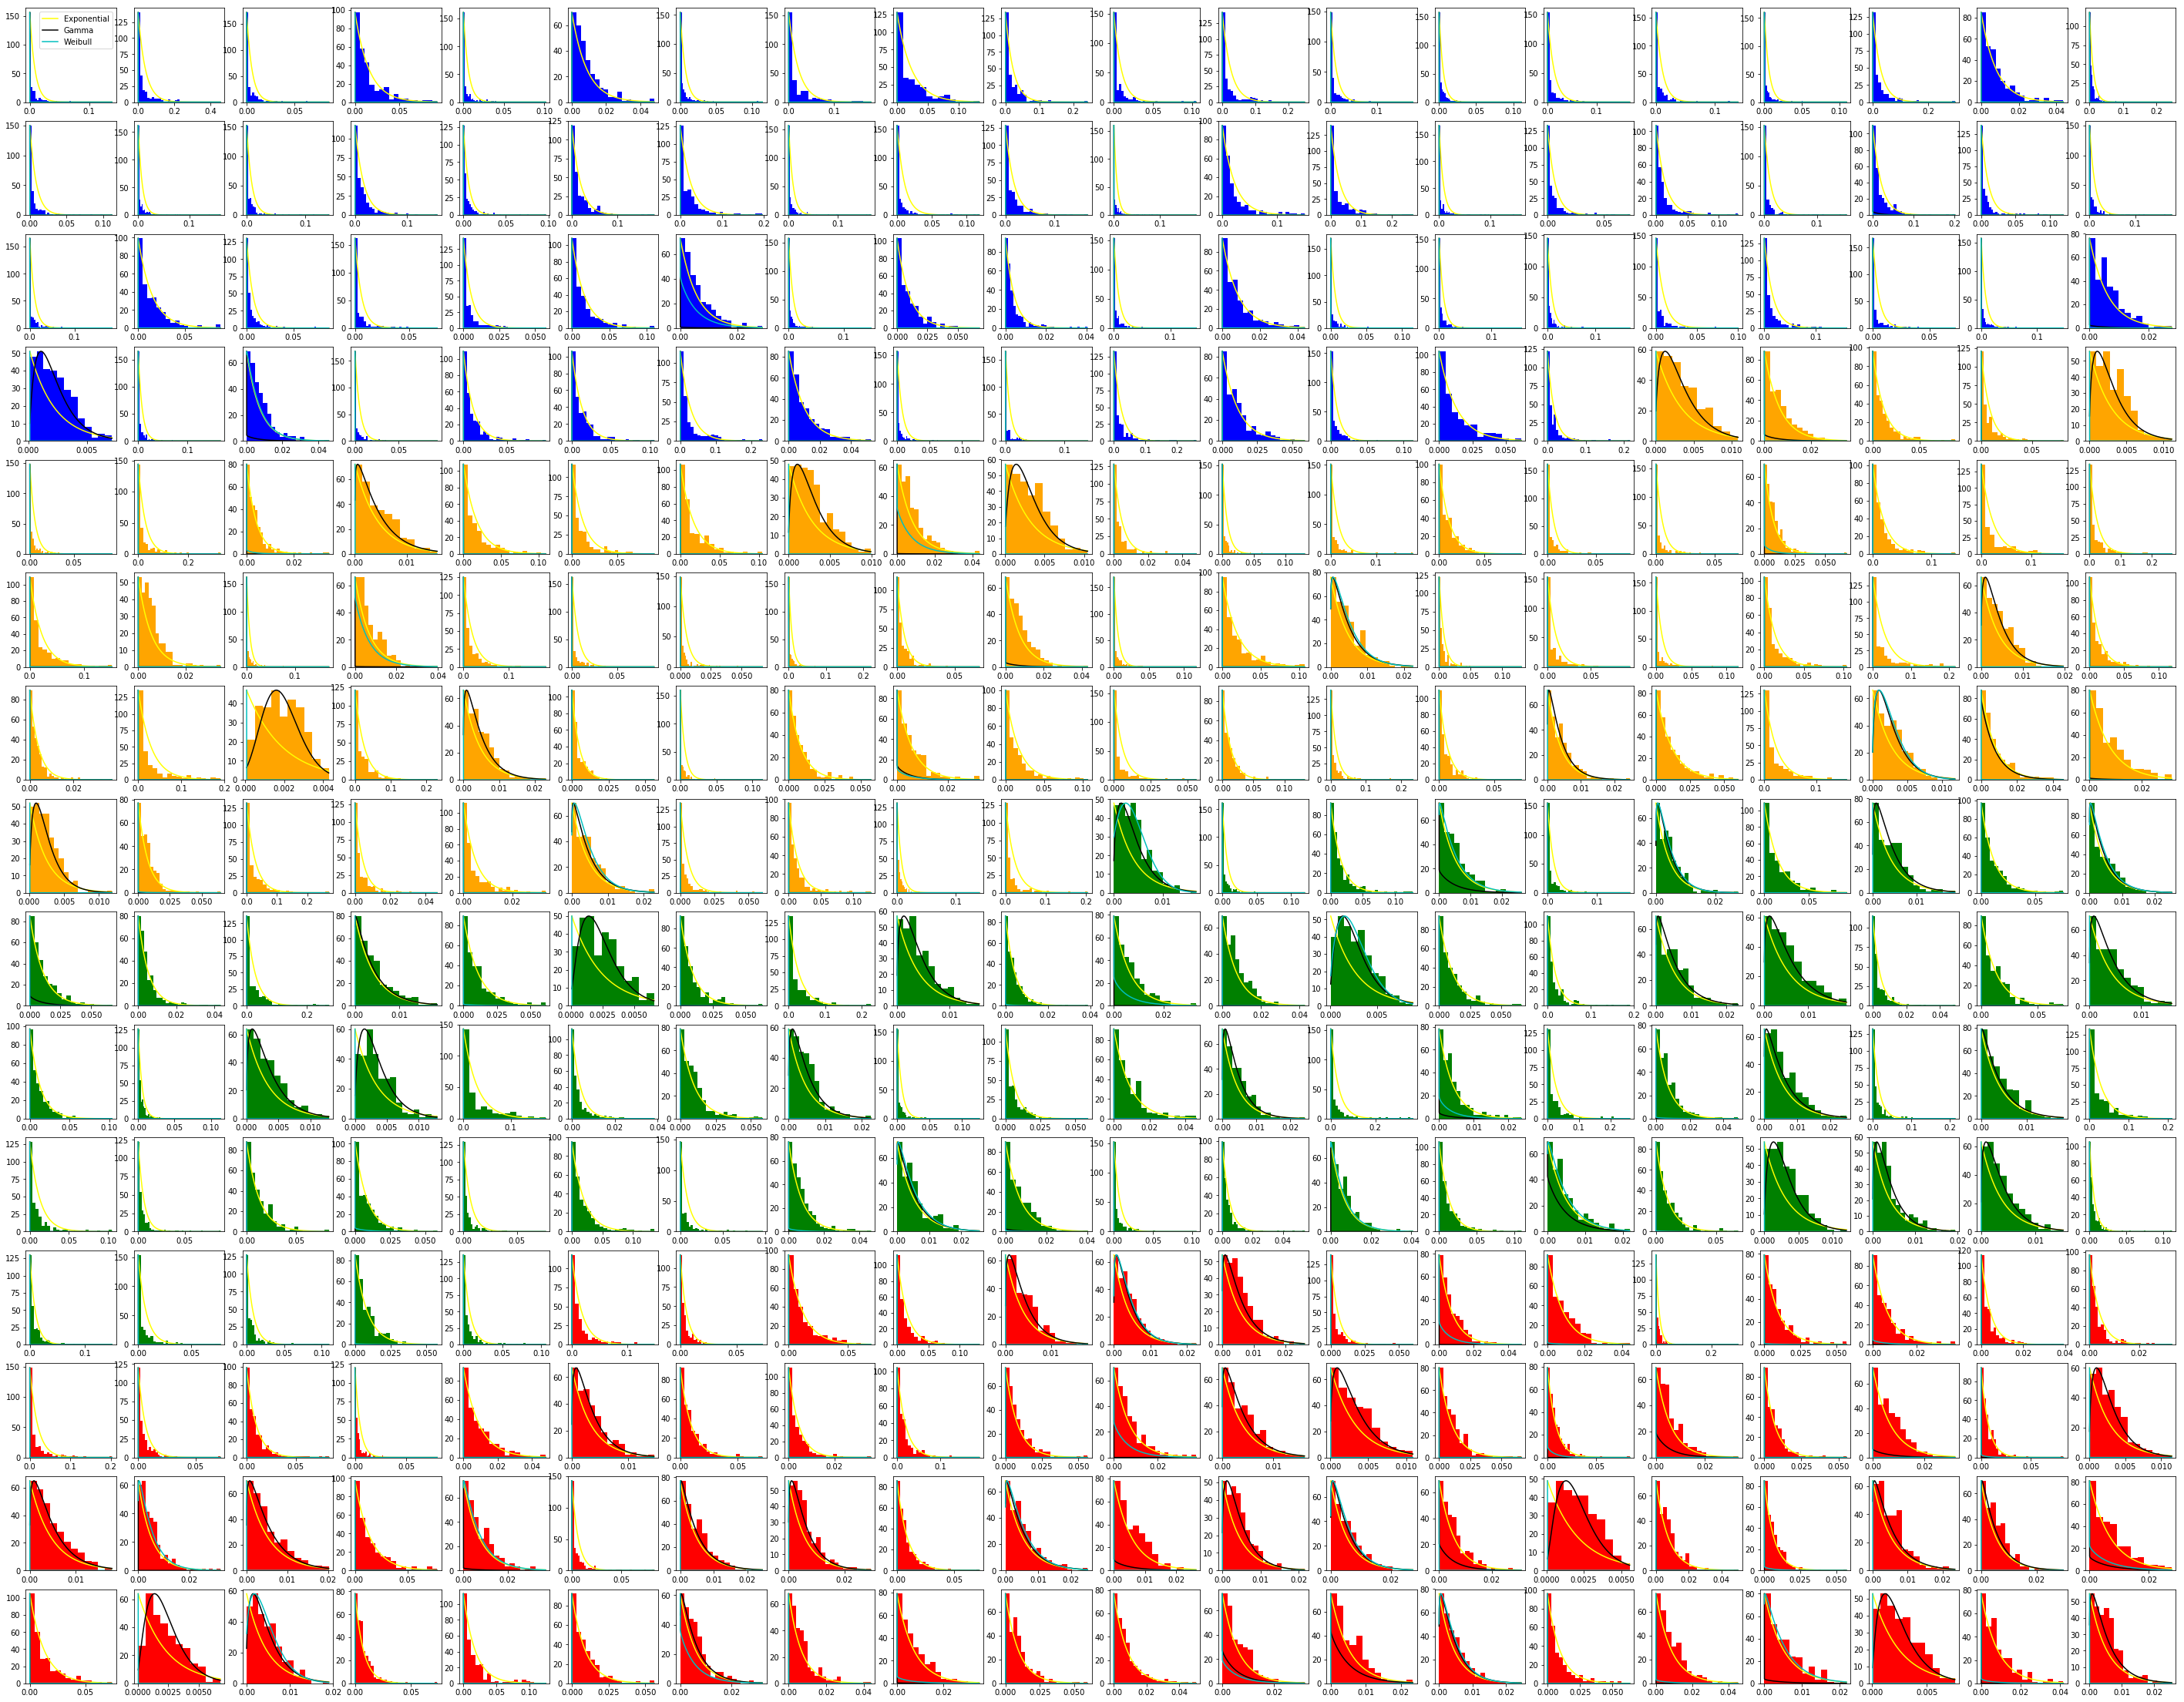

In [28]:
winnerBC=[]
fig=plt.figure(figsize=(50,40))
ax=[None]*len(bcData)
fitValsBC=[None]*len(bcData)
bicValsBC=[None]*len(bcData)

for i in tqdm(range(len(bcData))):
    ax[i]=fig.add_subplot(15,20,i+1)
    r=bcData[i]
    # Find Frequencies and Bins
    bin_heights, bin_borders = np.histogram(r, bins='auto')
    bin_widths = np.diff(bin_borders)
    bin_centers = bin_borders[:-1] + bin_widths / 2

    #Fit Values:
#     LN, loc, scale = lognorm.fit(r, floc=0)
    E = expon.fit(r)
#     PL = powerlaw.fit(r)
    WB = weibull_min.fit(r)
    G = gamma.fit(r)

    #Negative Log Likelihood:
    llG = np.sum(gamma.logpdf(r, G[0], loc=G[1], scale=G[2]) ) 
    llE = np.sum(expon.logpdf(r, E[0], E[1]))
#     llPL = np.sum(powerlaw.logpdf(r, PL[0], PL[1], PL[2]) ) 
#     llLM = np.sum(lognorm.logpdf(r, LN, loc=loc, scale=scale) ) 
    llWB = np.sum(weibull_min.logpdf(r, WB[0],WB[1],WB[2]) ) 

    #BIC:
    # BIC = -2 * LL + log(N) * k

    bicG = -2* llG + len(G)*np.log(len(r[0]))
    bicE = -2* llE + len(E)*np.log(len(r[0]))
#     bicPL = -2* llPL + len([llPL])*np.log(len(r[0]))
#     bicLM = -2* llLM + len([LN])*np.log(len(r[0]))
    bicWB = -2* llWB + len(WB)*np.log(len(r[0]))

    #Find length of x
    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

    #Plot Histogram
    if i < 75:
        color='b'
    elif i >=75 and i < 150:
        color = 'orange'
    elif i >=150 and i < 225:
        color = 'g'
    else:
        color = 'r'
    plt.bar(bin_centers, bin_heights, width=bin_widths,color=color)

    # Probability Density Function 
#     pdfLog = lognorm.pdf(x_interval_for_fit, LN, scale=scale)
    pdfExp = expon.pdf(x_interval_for_fit, *E)
#     pdfPwl = powerlaw.pdf(x_interval_for_fit,*PL)
    pdfGam = gamma.pdf(x_interval_for_fit,*G)
    pdfWB = weibull_min.pdf(x_interval_for_fit,*WB)

    #Renormalise scale:
#     pdfLog=scaleData(pdfLog,bin_heights)
    pdfExp=scaleData(pdfExp,bin_heights)
#     pdfPwl=scaleData(pdfPwl,bin_heights)
    pdfGam=scaleData(pdfGam,bin_heights)
    pdfWB=scaleData(pdfWB,bin_heights)

    #Plot fit on histogram
#     plt.plot(x_interval_for_fit, pdfLog, 'm',label='Log Norm')
    plt.plot(x_interval_for_fit, pdfExp, 'yellow',label='Exponential')
#     plt.plot(x_interval_for_fit, pdfPwl, 'c',label='Power Law')
    plt.plot(x_interval_for_fit, pdfGam, 'k',label='Gamma')
    plt.plot(x_interval_for_fit, pdfWB, 'c',label='Weibull')
    if i == 0:
        plt.legend(loc='best')

#     print(f'Gamma BIC: {bicG}')
#     print(f'Exponential BIC: {bicE}')
#     print(f'Power Law BIC: {bicPL}')
#     print(f'Log Normal BIC: {bicLM}')

    if bicG < bicE and bicG < bicWB: #and bicG < bicLM:
        winnerBC.append('Gamma')
    elif bicE < bicG and bicE < bicWB: #and bicE < bicLM:
        winnerBC.append('Exponential')
    elif bicWB < bicG and bicWB < bicE: #and bicWB < bicLM:
        winnerBC.append('Weibull') 
#     elif bicLM < bicG and bicLM < bicE and bicLM < bicWB:
#         winnerBC.append('Log Normal')  

    bicValsBC[i]={'Exponential':bicE,'Gamma':bicG,'Weibull':bicWB}
    fitValsBC[i]={'Exponential':E,'Gamma':G,'Weibull':WB}

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/All Networks Centrality Curve Fitting Histograms sorted by Accuracy.png',format='png',dpi=300)

In [30]:
compressed_pickle({'Degree':{'winners':winner,'fitvalues':fitVals,'BICvalues':bicVals},'PCoeff':{'winners':winnerPC,'fitvalues':fitValsPC,'BICvalues':bicValsPC},'Centrality':{'winners':winnerBC,'fitvalues':fitValsBC,'BICvalues':bicValsBC}},'CurveFits')

In [29]:
#equal bins

#sort asn_acc:
acc_sorted=np.sort(asn_acc)
acc_idx=np.argsort(asn_acc)

sorted_winner=[]
for idx in acc_idx:
    sorted_winner.append(winner[idx])
    
sorted_winnerPC=[]
for idx in acc_idx:
    sorted_winnerPC.append(winnerPC[idx])
    
    
sorted_winnerBC=[]
for idx in acc_idx:
    sorted_winnerBC.append(winnerBC[idx])

NameError: name 'asn_acc' is not defined

/suphys/aloe8475/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



TypeError: Empty 'DataFrame': no numeric data to plot

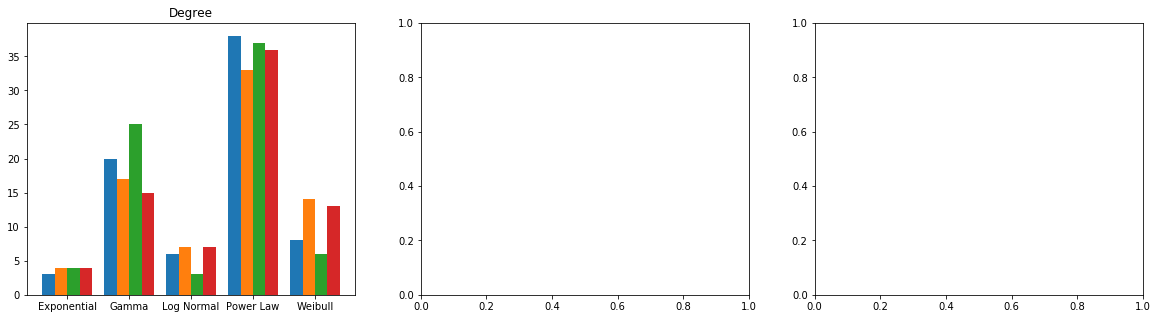

In [47]:
# ax=[None]*4
# ax[0]=fig.add_subplot(2,2,1)
# ax[0].set_title('All networks')
# bins = []
num_bins = 4
data_points_per_bin = len(sorted_winner) // num_bins
binnedACC = [sorted_winner[_ * data_points_per_bin: (_+1)*data_points_per_bin] for _ in range(num_bins)]# ax[1]=fig.add_subplot(2,2,3)
# h=plt.hist(np.sort(binnedACC).tolist(),bins=np.arange(4)-0.5)
# plt.legend(h[-1],['Min Accuracy','Min-Mid Accuracy','Mid-Max Accuracy','Max Accuracy'])



fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20,5))

new_df=pd.DataFrame()
labels=['Min Accuracy','Min-Mid Accuracy','Mid-Max Accuracy','Max Accuracy']
for i in range(len(binnedACC)):
    letter_counts = Counter(binnedACC[i])
    df = pandas.DataFrame.from_dict(letter_counts, orient='index')
    new_df=pd.concat([new_df, df], axis=1)
    
new_df.columns=[labels[i] for i,_ in enumerate(new_df.columns)]#rename columns
new_df.plot(ax=axes[0],kind='bar',rot=0,width=0.8,title='Degree',legend=False)
# plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/All Networks Degree Curve Fitting Binned by Accuracy.png',format='png',dpi=300)

new_df=pd.DataFrame()
labels=['Min Accuracy','Min-Mid Accuracy','Mid-Max Accuracy','Max Accuracy']
for i in range(len(binnedACC_PC)):
    letter_counts = Counter(binnedACC_PC[i])
    df = pandas.DataFrame.from_dict(letter_counts, orient='index')
    new_df=pd.concat([new_df, df], axis=1)
    
new_df.columns=[labels[i] for i,_ in enumerate(new_df.columns)]#rename columns
new_df.plot(ax=axes[1],kind='bar',rot=0,width=0.8,title='Participation Coefficient',legend=False)


new_df=pd.DataFrame()
labels=['Min Accuracy','Min-Mid Accuracy','Mid-Max Accuracy','Max Accuracy']
for i in range(len(binnedACC_BC)):
    letter_counts = Counter(binnedACC_BC[i])
    df = pandas.DataFrame.from_dict(letter_counts, orient='index')
    new_df=pd.concat([new_df, df], axis=1)
    
new_df.columns=[labels[i] for i,_ in enumerate(new_df.columns)]#rename columns
new_df.plot(ax=axes[2],kind='bar',rot=0,width=0.8,title='Betweenness Centrality').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))


# plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/All Networks Degree_PCoeff_Centrality Curve Fitting Binned by Accuracy.svg',format='svg',dpi=300)


/suphys/aloe8475/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



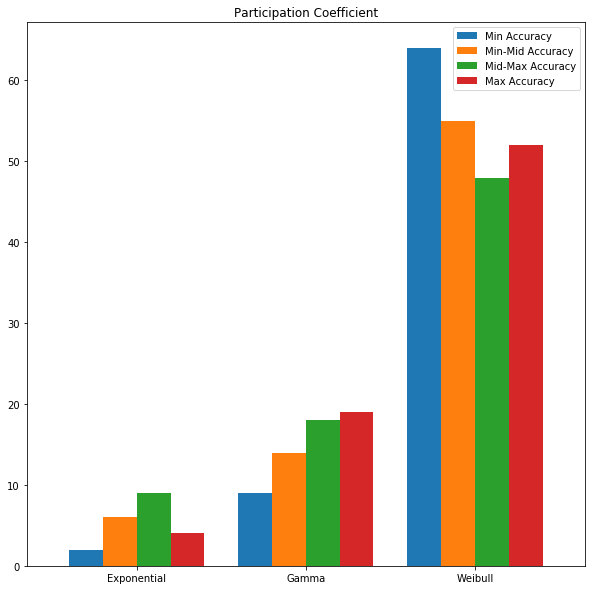

In [238]:
# fig=plt.figure(figsize=(10,10))
# # ax=[None]*4
# # ax[0]=fig.add_subplot(2,2,1)
# # ax[0].set_title('All networks')
# bins = []
num_bins = 4
data_points_per_bin = len(sorted_winnerPC) // num_bins
binnedACC_PC = [sorted_winnerPC[_ * data_points_per_bin: (_+1)*data_points_per_bin] for _ in range(num_bins)]# ax[1]=fig.add_subplot(2,2,3)
# h=plt.hist(np.sort(binnedACC_PC).tolist(),bins=np.arange(4)-0.5)
# plt.legend(h[-1],['Min Accuracy','Min-Mid Accuracy','Mid-Max Accuracy','Max Accuracy'])

new_df=pd.DataFrame()
labels=['Min Accuracy','Min-Mid Accuracy','Mid-Max Accuracy','Max Accuracy']
for i in range(len(binnedACC_PC)):
    letter_counts = Counter(binnedACC_PC[i])
    df = pandas.DataFrame.from_dict(letter_counts, orient='index')
    new_df=pd.concat([new_df, df], axis=1)
    
new_df.columns=[labels[i] for i,_ in enumerate(new_df.columns)]#rename columns
new_df.plot(kind='bar',figsize=(10,10),rot=0,width=0.8,title='Participation Coefficient')

# plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/All Networks PCoeff Curve Fitting Binned by Accuracy.png',format='png',dpi=300)

/suphys/aloe8475/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



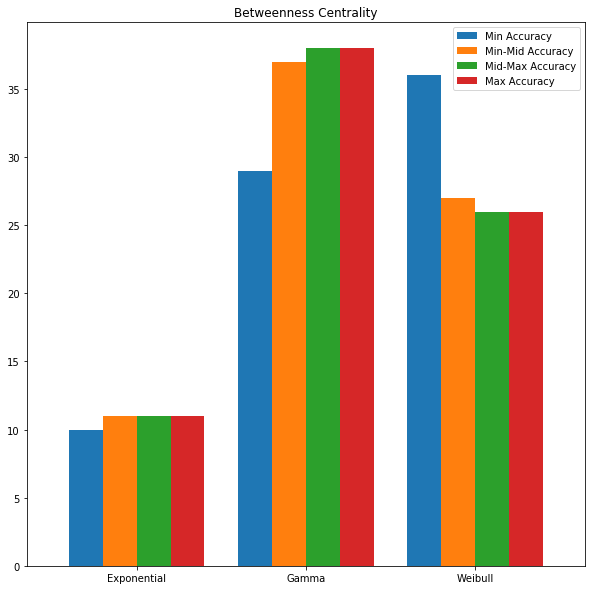

In [237]:
# fig=plt.figure(figsize=(10,10))
# # ax=[None]*4
# # ax[0]=fig.add_subplot(2,2,1)
# # ax[0].set_title('All networks')
# bins = []
# num_bins = 4
# data_points_per_bin = len(sorted_winnerBC) // num_bins
# binnedACC_BC = [sorted_winnerBC[_ * data_points_per_bin: (_+1)*data_points_per_bin] for _ in range(num_bins)]# ax[1]=fig.add_subplot(2,2,3)
# h=plt.hist(np.sort(binnedACC_BC).tolist(),bins=np.arange(4)-0.5)
# plt.legend(h[-1],['Min Accuracy','Min-Mid Accuracy','Mid-Max Accuracy','Max Accuracy'])

new_df=pd.DataFrame()
labels=['Min Accuracy','Min-Mid Accuracy','Mid-Max Accuracy','Max Accuracy']
for i in range(len(binnedACC_BC)):
    letter_counts = Counter(binnedACC_BC[i])
    df = pandas.DataFrame.from_dict(letter_counts, orient='index')
    new_df=pd.concat([new_df, df], axis=1)
    
new_df.columns=[labels[i] for i,_ in enumerate(new_df.columns)]#rename columns
new_df.plot(kind='bar',figsize=(10,10),rot=0,width=0.8,title='Betweenness Centrality')


plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/All Networks Centrality Curve Fitting Binned by Accuracy.png',format='png',dpi=300)

Text(0.5, 1.0, 'Max Accuracy Networks')

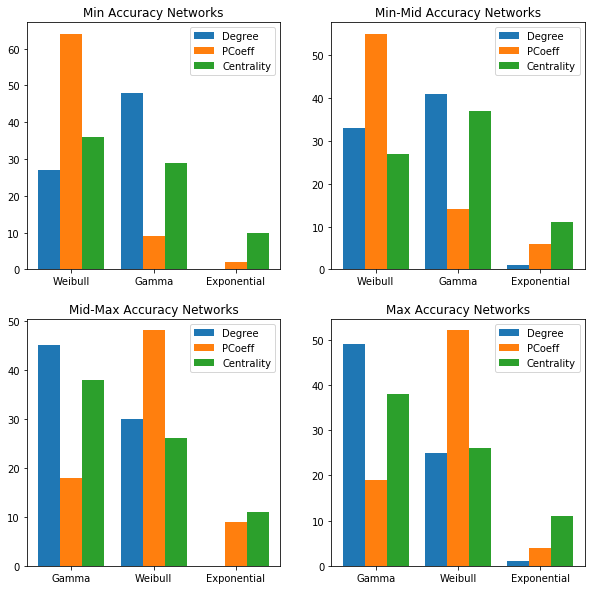

In [158]:
# MIN ACCURACY:
fig=plt.figure(figsize=(10,10))
ax=[None]*4

ax[0]=fig.add_subplot(2,2,1)
plt.hist([binnedACC[0],binnedACC_PC[0],binnedACC_BC[0]],label=['Degree','PCoeff','Centrality'],bins=np.arange(4)-0.5)
plt.legend()
plt.title('Min Accuracy Networks')

ax[1]=fig.add_subplot(2,2,2)
plt.hist([binnedACC[1],binnedACC_PC[1],binnedACC_BC[1]],label=['Degree','PCoeff','Centrality'],bins=np.arange(4)-0.5)
plt.legend()
plt.title('Min-Mid Accuracy Networks')

ax[2]=fig.add_subplot(2,2,3)
plt.hist([binnedACC[2],binnedACC_PC[2],binnedACC_BC[2]],label=['Degree','PCoeff','Centrality'],bins=np.arange(4)-0.5)
plt.legend()
plt.title('Mid-Max Accuracy Networks')

ax[3]=fig.add_subplot(2,2,4)
plt.hist([binnedACC[3],binnedACC_PC[3],binnedACC_BC[3]],label=['Degree','PCoeff','Centrality'],bins=np.arange(4)-0.5)
plt.legend()
plt.title('Max Accuracy Networks')

In [373]:
# # ax[1].set_title('Max Accuracy Networks')
# plt.hist(maxWinners)
# # ax[2]=fig.add_subplot(2,2,4)
# # ax[2].set_title('Min Accuracy Networks')
# plt.hist(minWinners)

In [40]:
curveData=decompress_pickle('/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/CurveFits')

In [67]:
idxGamma=[]
idxExpon=[]
idxWB=[]
for i in range(len(curveData['Degree']['winners'])):
    if curveData['Degree']['winners'][i]=='Gamma':
        idxGamma.append(i)
    elif curveData['Degree']['winners'][i]=='Exponential':
        idxExpon.append(i)
    elif curveData['Degree']['winners'][i]=='Weibull':
        idxWB.append(i)
        
idxGammaPC=[]
idxExponPC=[]
idxWBPC=[]
for i in range(len(curveData['PCoeff']['winners'])):
    if curveData['PCoeff']['winners'][i]=='Gamma':
        idxGammaPC.append(i)
    elif curveData['PCoeff']['winners'][i]=='Exponential':
        idxExponPC.append(i)
    elif curveData['PCoeff']['winners'][i]=='Weibull':
        idxWBPC.append(i)
        
idxGammaBC=[]
idxExponBC=[]
idxWBBC=[]
for i in range(len(curveData['Centrality']['winners'])):
    if curveData['Centrality']['winners'][i]=='Gamma':
        idxGammaBC.append(i)
    elif curveData['Centrality']['winners'][i]=='Exponential':
        idxExponBC.append(i)
    elif curveData['Centrality']['winners'][i]=='Weibull':
        idxWBBC.append(i)

In [69]:
#Degree:
GammaNWs=[]
for i in range(len(idxGamma)):
    if idxGamma[i] >= 100: 
        GammaNWs.append([int(float(idxGamma[i])/10),list(map(int, str(idxGamma[i])))[-1]])
    elif idxGamma[i] <10: 
        GammaNWs.append([0, list(map(int, str(idxGamma[i])))[-1]])
    else:
        GammaNWs.append(list(map(int, str(idxGamma[i]))))
        
ExponNWs=[]
for i in range(len(idxExpon)):
    if idxExpon[i] >= 100: 
        ExponNWs.append([int(float(idxExpon[i])/10),list(map(int, str(idxExpon[i])))[-1]])
    elif idxExpon[i] <10: 
        ExponNWs.append([0, list(map(int, str(idxExpon[i])))[-1]])
    else:
        ExponNWs.append(list(map(int, str(idxExpon[i]))))

WeibulNWs=[]
for i in range(len(idxWB)):
    if idxWB[i] >= 100: 
        WeibulNWs.append([int(float(idxWB[i])/10),list(map(int, str(idxWB[i])))[-1]])
    elif idxWB[i] <10: 
        WeibulNWs.append([0, list(map(int, str(idxWB[i])))[-1]])
    else:
        WeibulNWs.append(list(map(int, str(idxWB[i]))))
        
        
# PCoeff
GammaNWsPC=[]
for i in range(len(idxGammaPC)):
    if idxGammaPC[i] >= 100: 
        GammaNWsPC.append([int(float(idxGammaPC[i])/10),list(map(int, str(idxGammaPC[i])))[-1]])
    elif idxGammaPC[i] <10: 
        GammaNWsPC.append([0, list(map(int, str(idxGammaPC[i])))[-1]])
    else:
        GammaNWsPC.append(list(map(int, str(idxGammaPC[i]))))
        
ExponNWsPC=[]
for i in range(len(idxExponPC)):
    if idxExponPC[i] >= 100: 
        ExponNWsPC.append([int(float(idxExponPC[i])/10),list(map(int, str(idxExponPC[i])))[-1]])
    elif idxExponPC[i] <10: 
        ExponNWsPC.append([0, list(map(int, str(idxExponPC[i])))[-1]])
    else:
        ExponNWsPC.append(list(map(int, str(idxExponPC[i]))))

WeibulNWsPC=[]
for i in range(len(idxWBPC)):
    if idxWBPC[i] >= 100: 
        WeibulNWsPC.append([int(float(idxWBPC[i])/10),list(map(int, str(idxWBPC[i])))[-1]])
    elif idxWBPC[i] <10: 
        WeibulNWsPC.append([0, list(map(int, str(idxWBPC[i])))[-1]])
    else:
        WeibulNWsPC.append(list(map(int, str(idxWBPC[i]))))
        
        
# Centrality
GammaNWsBC=[]
for i in range(len(idxGammaBC)):
    if idxGammaBC[i] >= 100: 
        GammaNWsBC.append([int(float(idxGammaBC[i])/10),list(map(int, str(idxGammaBC[i])))[-1]])
    elif idxGammaBC[i] <10: 
        GammaNWsBC.append([0, list(map(int, str(idxGammaBC[i])))[-1]])
    else:
        GammaNWsBC.append(list(map(int, str(idxGammaBC[i]))))
        
ExponNWsBC=[]
for i in range(len(idxExponBC)):
    if idxExponBC[i] >= 100: 
        ExponNWsBC.append([int(float(idxExponBC[i])/10),list(map(int, str(idxExponBC[i])))[-1]])
    elif idxExponBC[i] <10: 
        ExponNWsBC.append([0, list(map(int, str(idxExponBC[i])))[-1]])
    else:
        ExponNWsBC.append(list(map(int, str(idxExponBC[i]))))

WeibulNWsBC=[]
for i in range(len(idxWBBC)):
    if idxWBBC[i] >= 100: 
        WeibulNWsBC.append([int(float(idxWBBC[i])/10),list(map(int, str(idxWBBC[i])))[-1]])
    elif idxWBBC[i] <10: 
        WeibulNWsBC.append([0, list(map(int, str(idxWBBC[i])))[-1]])
    else:
        WeibulNWsBC.append(list(map(int, str(idxWBBC[i]))))

In [71]:
#Degree
allCol=[None]*300
count=0
for i in range(len(ASN300)):
    for j in range(len(ASN300[i])):
        allCol[count]=(np.max(ASN300[i][j]['Accuracy']['Linear Transformation']))
        count=count+1
X_PL=[]
Y_PL=[[None]*len(WeibulNWs) for i in range(6)]
acc_PL=[]
for i in range(len(WeibulNWs)):
    medDegree=np.median([val for (node, val) in ASN300[WeibulNWs[i][0]][WeibulNWs[i][1]]['G'].degree()])
    stdDegree=np.std([val for (node, val) in ASN300[WeibulNWs[i][0]][WeibulNWs[i][1]]['G'].degree()])
    minDegree=np.min([val for (node, val) in ASN300[WeibulNWs[i][0]][WeibulNWs[i][1]]['G'].degree()])
    maxDegree=np.max([val for (node, val) in ASN300[WeibulNWs[i][0]][WeibulNWs[i][1]]['G'].degree()])
    kurtDegree=kurtosis([val for (node, val) in ASN300[WeibulNWs[i][0]][WeibulNWs[i][1]]['G'].degree()])
    Y_PL[1][i]=(medDegree)
    Y_PL[2][i]=(stdDegree)
    Y_PL[3][i]=(minDegree)
    Y_PL[4][i]=(maxDegree)
    Y_PL[5][i]=(kurtDegree)                       
    avgDegree_PL=np.mean([val for (node, val) in ASN300[WeibulNWs[i][0]][WeibulNWs[i][1]]['G'].degree()])
    X_PL.append([ASN300[WeibulNWs[i][0]][WeibulNWs[i][1]]['Graph Theory']['Small World']])
    Y_PL[0][i]=(avgDegree_PL)
    acc_PL.append(np.max(ASN300[WeibulNWs[i][0]][WeibulNWs[i][1]]['Accuracy']['Linear Transformation']))
  
X_G=[]
Y_G=[[None]*len(GammaNWs) for i in range(6)]
acc_G=[]
for i in range(len(GammaNWs)):
    medDegree=np.median([val for (node, val) in ASN300[GammaNWs[i][0]][GammaNWs[i][1]]['G'].degree()])
    stdDegree=np.std([val for (node, val) in ASN300[GammaNWs[i][0]][GammaNWs[i][1]]['G'].degree()])
    minDegree=np.min([val for (node, val) in ASN300[GammaNWs[i][0]][GammaNWs[i][1]]['G'].degree()])
    maxDegree=np.max([val for (node, val) in ASN300[GammaNWs[i][0]][GammaNWs[i][1]]['G'].degree()])
    kurtDegree=kurtosis([val for (node, val) in ASN300[GammaNWs[i][0]][GammaNWs[i][1]]['G'].degree()])
    Y_G[1][i]=(medDegree)
    Y_G[2][i]=(stdDegree)
    Y_G[3][i]=(minDegree)
    Y_G[4][i]=(maxDegree)
    Y_G[5][i]=(kurtDegree)                       
    avgDegree_G=np.mean([val for (node, val) in ASN300[GammaNWs[i][0]][GammaNWs[i][1]]['G'].degree()])
    X_G.append([ASN300[GammaNWs[i][0]][GammaNWs[i][1]]['Graph Theory']['Small World']])
    Y_G[0][i]=(avgDegree_G)
    acc_G.append(np.max(ASN300[GammaNWs[i][0]][GammaNWs[i][1]]['Accuracy']['Linear Transformation']))
    
X_E=[]
Y_E=[[None]*len(ExponNWs) for i in range(6)]
acc_E=[]
for i in range(len(ExponNWs)):
    medDegree=np.median([val for (node, val) in ASN300[ExponNWs[i][0]][ExponNWs[i][1]]['G'].degree()])
    stdDegree=np.std([val for (node, val) in ASN300[ExponNWs[i][0]][ExponNWs[i][1]]['G'].degree()])
    minDegree=np.min([val for (node, val) in ASN300[ExponNWs[i][0]][ExponNWs[i][1]]['G'].degree()])
    maxDegree=np.max([val for (node, val) in ASN300[ExponNWs[i][0]][ExponNWs[i][1]]['G'].degree()])
    kurtDegree=kurtosis([val for (node, val) in ASN300[ExponNWs[i][0]][ExponNWs[i][1]]['G'].degree()])
    Y_E[1][i]=(medDegree)
    Y_E[2][i]=(stdDegree)
    Y_E[3][i]=(minDegree)
    Y_E[4][i]=(maxDegree)
    Y_E[5][i]=(kurtDegree)                       
    avgDegree_G=np.mean([val for (node, val) in ASN300[ExponNWs[i][0]][ExponNWs[i][1]]['G'].degree()])
    X_E.append([ASN300[ExponNWs[i][0]][ExponNWs[i][1]]['Graph Theory']['Small World']])
    Y_E[0][i]=(avgDegree_G)
    acc_E.append(np.max(ASN300[ExponNWs[i][0]][ExponNWs[i][1]]['Accuracy']['Linear Transformation']))
                        

In [72]:
#PCoeff
X_PL_PC=[]
Y_PL_PC=[]
acc_PL_PC=[]
for i in range(len(WeibulNWsPC)):
    X_PL_PC.append([ASN300[WeibulNWsPC[i][0]][WeibulNWsPC[i][1]]['Graph Theory']['Small World']])
    Y_PL_PC.append([ASN300[WeibulNWsPC[i][0]][WeibulNWsPC[i][1]]['Graph Theory']['PCoeff']])
    acc_PL_PC.append(np.max(ASN300[WeibulNWsPC[i][0]][WeibulNWsPC[i][1]]['Accuracy']['Linear Transformation']))
  
X_G_PC=[]
Y_G_PC=[]
acc_G_PC=[]
for i in range(len(GammaNWsPC)):
    X_G_PC.append([ASN300[GammaNWsPC[i][0]][GammaNWsPC[i][1]]['Graph Theory']['Small World']])
    Y_G_PC.append([ASN300[GammaNWsPC[i][0]][GammaNWsPC[i][1]]['Graph Theory']['PCoeff']])
    acc_G_PC.append(np.max(ASN300[GammaNWsPC[i][0]][GammaNWsPC[i][1]]['Accuracy']['Linear Transformation']))
    
X_E_PC=[]
Y_E_PC=[]
acc_E_PC=[]
for i in range(len(ExponNWsPC)):
    X_E_PC.append([ASN300[ExponNWsPC[i][0]][ExponNWsPC[i][1]]['Graph Theory']['Small World']])
    Y_E_PC.append([ASN300[ExponNWsPC[i][0]][ExponNWsPC[i][1]]['Graph Theory']['PCoeff']])
    acc_E_PC.append(np.max(ASN300[ExponNWsPC[i][0]][ExponNWsPC[i][1]]['Accuracy']['Linear Transformation']))
                        

In [79]:
#Centrality
X_PL_BC=[]
Y_PL_BC=[]
acc_PL_BC=[]
for i in range(len(WeibulNWsBC)):
    X_PL_BC.append([ASN300[WeibulNWsBC[i][0]][WeibulNWsBC[i][1]]['Graph Theory']['Small World']])
    Y_PL_BC.append(list(nx.betweenness_centrality(ASN300[WeibulNWsBC[i][0]][WeibulNWsBC[i][1]]['G']).values()))
    acc_PL_BC.append(np.max(ASN300[WeibulNWsBC[i][0]][WeibulNWsBC[i][1]]['Accuracy']['Linear Transformation']))
  
X_G_BC=[]
Y_G_BC=[]
acc_G_BC=[]
for i in range(len(GammaNWsBC)):
    X_G_BC.append([ASN300[GammaNWsBC[i][0]][GammaNWsBC[i][1]]['Graph Theory']['Small World']])
    Y_G_BC.append(list(nx.betweenness_centrality(ASN300[GammaNWsBC[i][0]][GammaNWsBC[i][1]]['G']).values()))
    acc_G_BC.append(np.max(ASN300[GammaNWsBC[i][0]][GammaNWsBC[i][1]]['Accuracy']['Linear Transformation']))
    
X_E_BC=[]
Y_E_BC=[]
acc_E_BC=[]
for i in range(len(ExponNWsBC)):
    X_E_BC.append([ASN300[ExponNWsBC[i][0]][ExponNWsBC[i][1]]['Graph Theory']['Small World']])
    Y_E_BC.append(list(nx.betweenness_centrality(ASN300[ExponNWsBC[i][0]][ExponNWsBC[i][1]]['G']).values()))
    acc_E_BC.append(np.max(ASN300[ExponNWsBC[i][0]][ExponNWsBC[i][1]]['Accuracy']['Linear Transformation']))
                        

KeyboardInterrupt: 

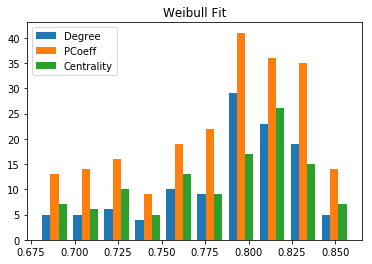

In [78]:
plt.hist([acc_PL,acc_PL_PC,acc_PL_BC],label=['Degree','PCoeff','Centrality'])
plt.title('Weibull Fit')
plt.legend()

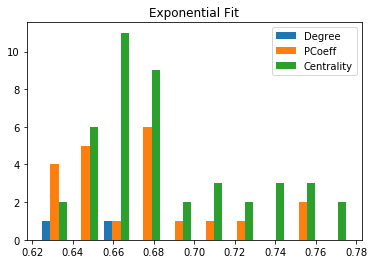

In [75]:
plt.hist([X_E,X_E_PC,X_E_BC],label=['Degree','PCoeff','Centrality'])
plt.title('Exponential Fit')
plt.legend()

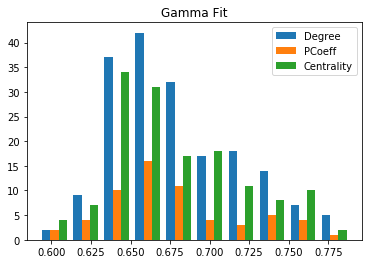

In [76]:
plt.hist([X_G,X_G_PC,X_G_BC],label=['Degree','PCoeff','Centrality'])
plt.title('Gamma Fit')
plt.legend()

Text(0.5, 1.0, 'Gamma Degree Curve Networks')

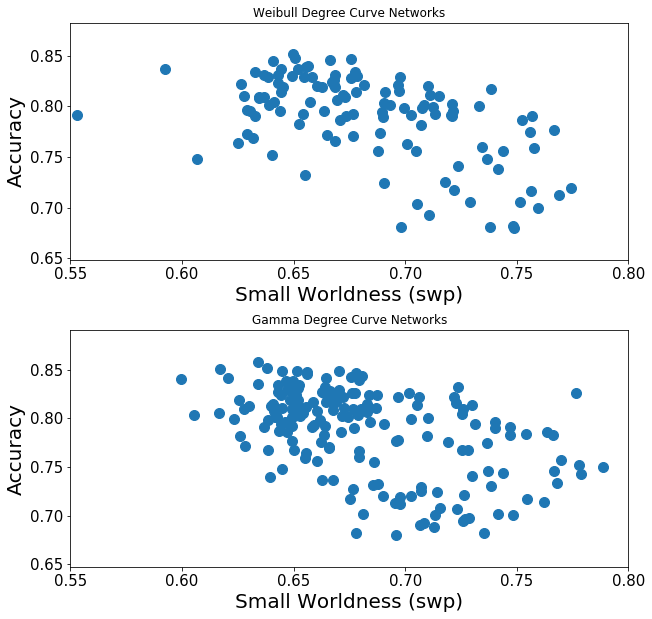

In [388]:

X_PL=np.asanyarray(X_PL)
Y_PL[0]=np.asanyarray(Y_PL[0])
ax=[None]*2
fig=plt.figure(figsize=(10,10))

ax[0]=fig.add_subplot(2,1,1)
p=plt.scatter(X_PL,acc_PL,s=100)#,cmap=plt.cm.inferno,c=acc_PL,label='ASN',s=100)#,cmap=plt.cm.afmhot,c=col,s=20,alpha=1)
# cb=fig.colorbar(p)
plt.xlabel('Small Worldness (swp)',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.xlim([0.55,0.8])
# plt.title('Four Networks: 1) Min SW 2) Max SW 3) Min Accuracy 4) Max Accuracy ')
plt.clim(np.min(allCol),np.max(allCol))
# cb=fig.colorbar(p,ax=plt.gca())
ax[0].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
ax[0].tick_params(axis='both', which='minor', labelsize=15)
ax[0].set_title('Weibull Degree Curve Networks')
# cb.set_label(label='NonLinear Transformation Accuracy', size=15)
# cb.ax.tick_params(labelsize=15)

fig.subplots_adjust(hspace=.3)

X_G=np.asanyarray(X_G)
Y_G[0]=np.asanyarray(Y_G[0])
ax[1]=fig.add_subplot(2,1,2)
p=plt.scatter(X_G,acc_G,s=100)#,cmap=plt.cm.inferno,c=acc_G,label='ASN',s=100)#,cmap=plt.cm.afmhot,c=col,s=20,alpha=1)
# cb=fig.colorbar(p)
plt.xlim([0.55,0.8])

plt.xlabel('Small Worldness (swp)',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
# plt.title('Four Networks: 1) Min SW 2) Max SW 3) Min Accuracy 4) Max Accuracy ')
plt.clim(np.min(allCol),np.max(allCol))
# cb=fig.colorbar(p,ax=plt.gca())
ax[1].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
ax[1].tick_params(axis='both', which='minor', labelsize=15)
ax[1].set_title('Gamma Degree Curve Networks')
# cb.set_label(label='NonLinear Transformation Accuracy', size=15)
# cb.ax.tick_params(labelsize=15)

In [38]:
X_PL

NameError: name 'X_PL' is not defined

## Scale-Free Networks

In [12]:
#Nonlinear Transformation
name='/import/silo2/aloe8475/Documents/CODE/Analysis/Functional Connectivity/Functional Tasks/BA_Allnetworks_LinearTransformation.pkl'
print('Loading BA')
file = open(name, 'rb')
[BA_scaleFree] = pickle.load(file)
print('Loaded')

Loading BA
Loaded


In [14]:
import scipy.stats as stats    
degree=[None]*300
pcoeff=[None]*300
mz=[None]*300
centrality=[None]*300
#Gamma, Exponential, WB, Power Law Fitting:
count=0
for i in tqdm(range(len(BA_scaleFree))):
    degree[count]=(list(dict(BA_scaleFree[i]['Graph Theory']['Degree']).values()))  
    pcoeff[count]=(list(BA_scaleFree[i]['Graph Theory']['PCoeff']))        
    centrality[count]=(list(nx.betweenness_centrality(BA_scaleFree[i]['G']).values()))  
    mz[count]=(list(BA_scaleFree[i]['Graph Theory']['MZ']))
    count+=1

In [15]:
# SORT 50 x 50 / 300 x 300 BY ACCURACY:
ba_acc=[]
ba_mod=[]
ba_avgDeg=[]
degree_ba=[]
for i in range(len(BA_scaleFree)):
    degree_ba.append([val for (node, val) in BA_scaleFree[i]['G'].degree()])
    ba_acc.append(np.nanmax(BA_scaleFree[i]['Accuracy']['Linear Transformation']))
    ba_mod.append(np.nanmax(BA_scaleFree[i]['Graph Theory']['Modularity Score']))
    ba_avgDeg.append(np.mean(degree_ba[i]))
    
    
ba_sorted=np.sort(ba_acc)
ba_idx=np.argsort(ba_acc)

baIDX=[]        
for i in range(len(ba_idx)):
    if ba_idx[i] >= 100: 
        baIDX.append([int(float(ba_idx[i])/10),list(map(int, str(ba_idx[i])))[-1]])
    elif ba_idx[i] <10: 
        baIDX.append([0, list(map(int, str(ba_idx[i])))[-1]])
    else:
        baIDX.append(list(map(int, str(ba_idx[i]))))

In [16]:
#Sort Degree by accuracy^
degreeData=[]
for idx in ba_idx:
    degreeData.append(degree[idx])

In [17]:
#Sort PCoeff by accuracy^
pcoeffData=[]
for idx in ba_idx:
    pcoeffData.append(pcoeff[idx])

In [18]:
#Sort MZ by accuracy^
mzData=[]
for idx in ba_idx:
    mzData.append(mz[idx])

In [19]:
#Sort Centrality by accuracy^
bcData=[]
for idx in ba_idx:
    bcData.append(centrality[idx])

In [ ]:
winner=[]
fig=plt.figure(figsize=(50,40))
ax=[None]*len(degreeData)
fitVals=[None]*len(degreeData)
bicVals=[None]*len(degreeData)

for i in tqdm(range(len(degreeData))):
    ax[i]=fig.add_subplot(15,20,i+1)
    r=degreeData[i]
    # Find Frequencies and Bins
    bin_heights, bin_borders = np.histogram(r, bins='auto')
    bin_widths = np.diff(bin_borders)
    bin_centers = bin_borders[:-1] + bin_widths / 2

    #Fit Values:
    LN, loc, scale = lognorm.fit(r, floc=0)
    E = expon.fit(r)
    PL = powerlaw.fit(r)
    WB = weibull_min.fit(r)
    G = gamma.fit(r)

    #Negative Log Likelihood:
    llG = np.sum(gamma.logpdf(r, G[0], loc=G[1], scale=G[2]) ) 
    llE = np.sum(expon.logpdf(r, E[0], E[1]))
    llPL = np.sum(powerlaw.logpdf(r, PL[0], PL[1], PL[2]) ) 
    llLM = np.sum(lognorm.logpdf(r, LN, loc=loc, scale=scale) ) 
    llWB = np.sum(weibull_min.logpdf(r, WB[0],WB[1],WB[2]) ) 

    #BIC:
    # BIC = -2 * LL + log(N) * k

    bicG = -2* llG + len(G)*np.log(len(r))
    bicE = -2* llE + len(E)*np.log(len(r))
    bicPL = -2* llPL + len([llPL])*np.log(len(r))
    bicLM = -2* llLM + len([LN])*np.log(len(r))
    bicWB = -2* llWB + len(WB)*np.log(len(r))

    #Find length of x
    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

    #Plot Histogram
    if i < 75:
        color='b'
    elif i >=75 and i < 150:
        color = 'orange'
    elif i >=150 and i < 225:
        color = 'g'
    else:
        color = 'r'
    plt.bar(bin_centers, bin_heights, width=bin_widths,color=color)
    plt.ylim([0,150])
    plt.xlim([0,220])

    # Probability Density Function 
    pdfLog = lognorm.pdf(x_interval_for_fit, LN, scale=scale)
    pdfExp = expon.pdf(x_interval_for_fit, *E)
    pdfPwl = powerlaw.pdf(x_interval_for_fit,*PL)
    pdfGam = gamma.pdf(x_interval_for_fit,*G)
    pdfWB = weibull_min.pdf(x_interval_for_fit,*WB)

    #Renormalise scale:
    pdfLog=scaleData(pdfLog,bin_heights)
    pdfExp=scaleData(pdfExp,bin_heights)
    pdfPwl=scaleData(pdfPwl,bin_heights)
    pdfGam=scaleData(pdfGam,bin_heights)
    pdfWB=scaleData(pdfWB,bin_heights)

    #Plot fit on histogram
    plt.plot(x_interval_for_fit, pdfLog, 'm',label='Log Norm')
    plt.plot(x_interval_for_fit, pdfExp, 'yellow',label='Exponential')
    plt.plot(x_interval_for_fit, pdfPwl, 'g',label='Power Law')
    plt.plot(x_interval_for_fit, pdfGam, 'k',label='Gamma')
    plt.plot(x_interval_for_fit, pdfWB, 'c',label='Weibull')
    if i == 0:
        plt.legend(loc='best')

#     print(f'Gamma BIC: {bicG}')
#     print(f'Exponential BIC: {bicE}')
#     print(f'Power Law BIC: {bicPL}')
#     print(f'Log Normal BIC: {bicLM}')

    if bicG < bicE and bicG < bicWB and bicG < bicLM and bicG < bicPL:
        winner.append('Gamma')
    elif bicE < bicG and bicE < bicWB and bicE < bicLM and bicE < bicPL:
        winner.append('Exponential')
    elif bicWB < bicG and bicWB < bicE and bicWB < bicLM and bicWB < bicPL:
        winner.append('Weibull') 
    elif bicLM < bicG and bicLM < bicE and bicLM < bicWB and bicLM < bicPL:
        winner.append('Log Normal')  
    elif bicPL < bicG and bicPL < bicE and bicPL < bicWB and bicPL < bicLM:
        winner.append('Power Law')  

    bicVals[i]={'Exponential':bicE,'Gamma':bicG,'Log Normal':bicLM,'Weibull':bicWB, 'Power Law':bicPL}
    fitVals[i]={'Exponential':E,'Gamma':G,'Log Normal':LN,'Weibull':WB,'Power Law':PL}

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/BA Networks Curve Fitting Histograms sorted by Accuracy.png',format='png',dpi=300)

In [25]:
print('All Networks:')
print('Num Gamma Best Fit = ' + str(winner.count('Gamma')))
print('Num Weibull Best Fit = ' + str(winner.count('Weibull')))
print('Num Exponential Best Fit = ' + str(winner.count('Exponential')))
print('Num Log Normal Best Fit = ' + str(winner.count('Log Normal')))
print('Num Power Law Best Fit = ' + str(winner.count('Power Law')))


All Networks:
Num Gamma Best Fit = 77
Num Weibull Best Fit = 41
Num Exponential Best Fit = 15
Num Log Normal Best Fit = 23
Num Power Law Best Fit = 144


### PCOEFF

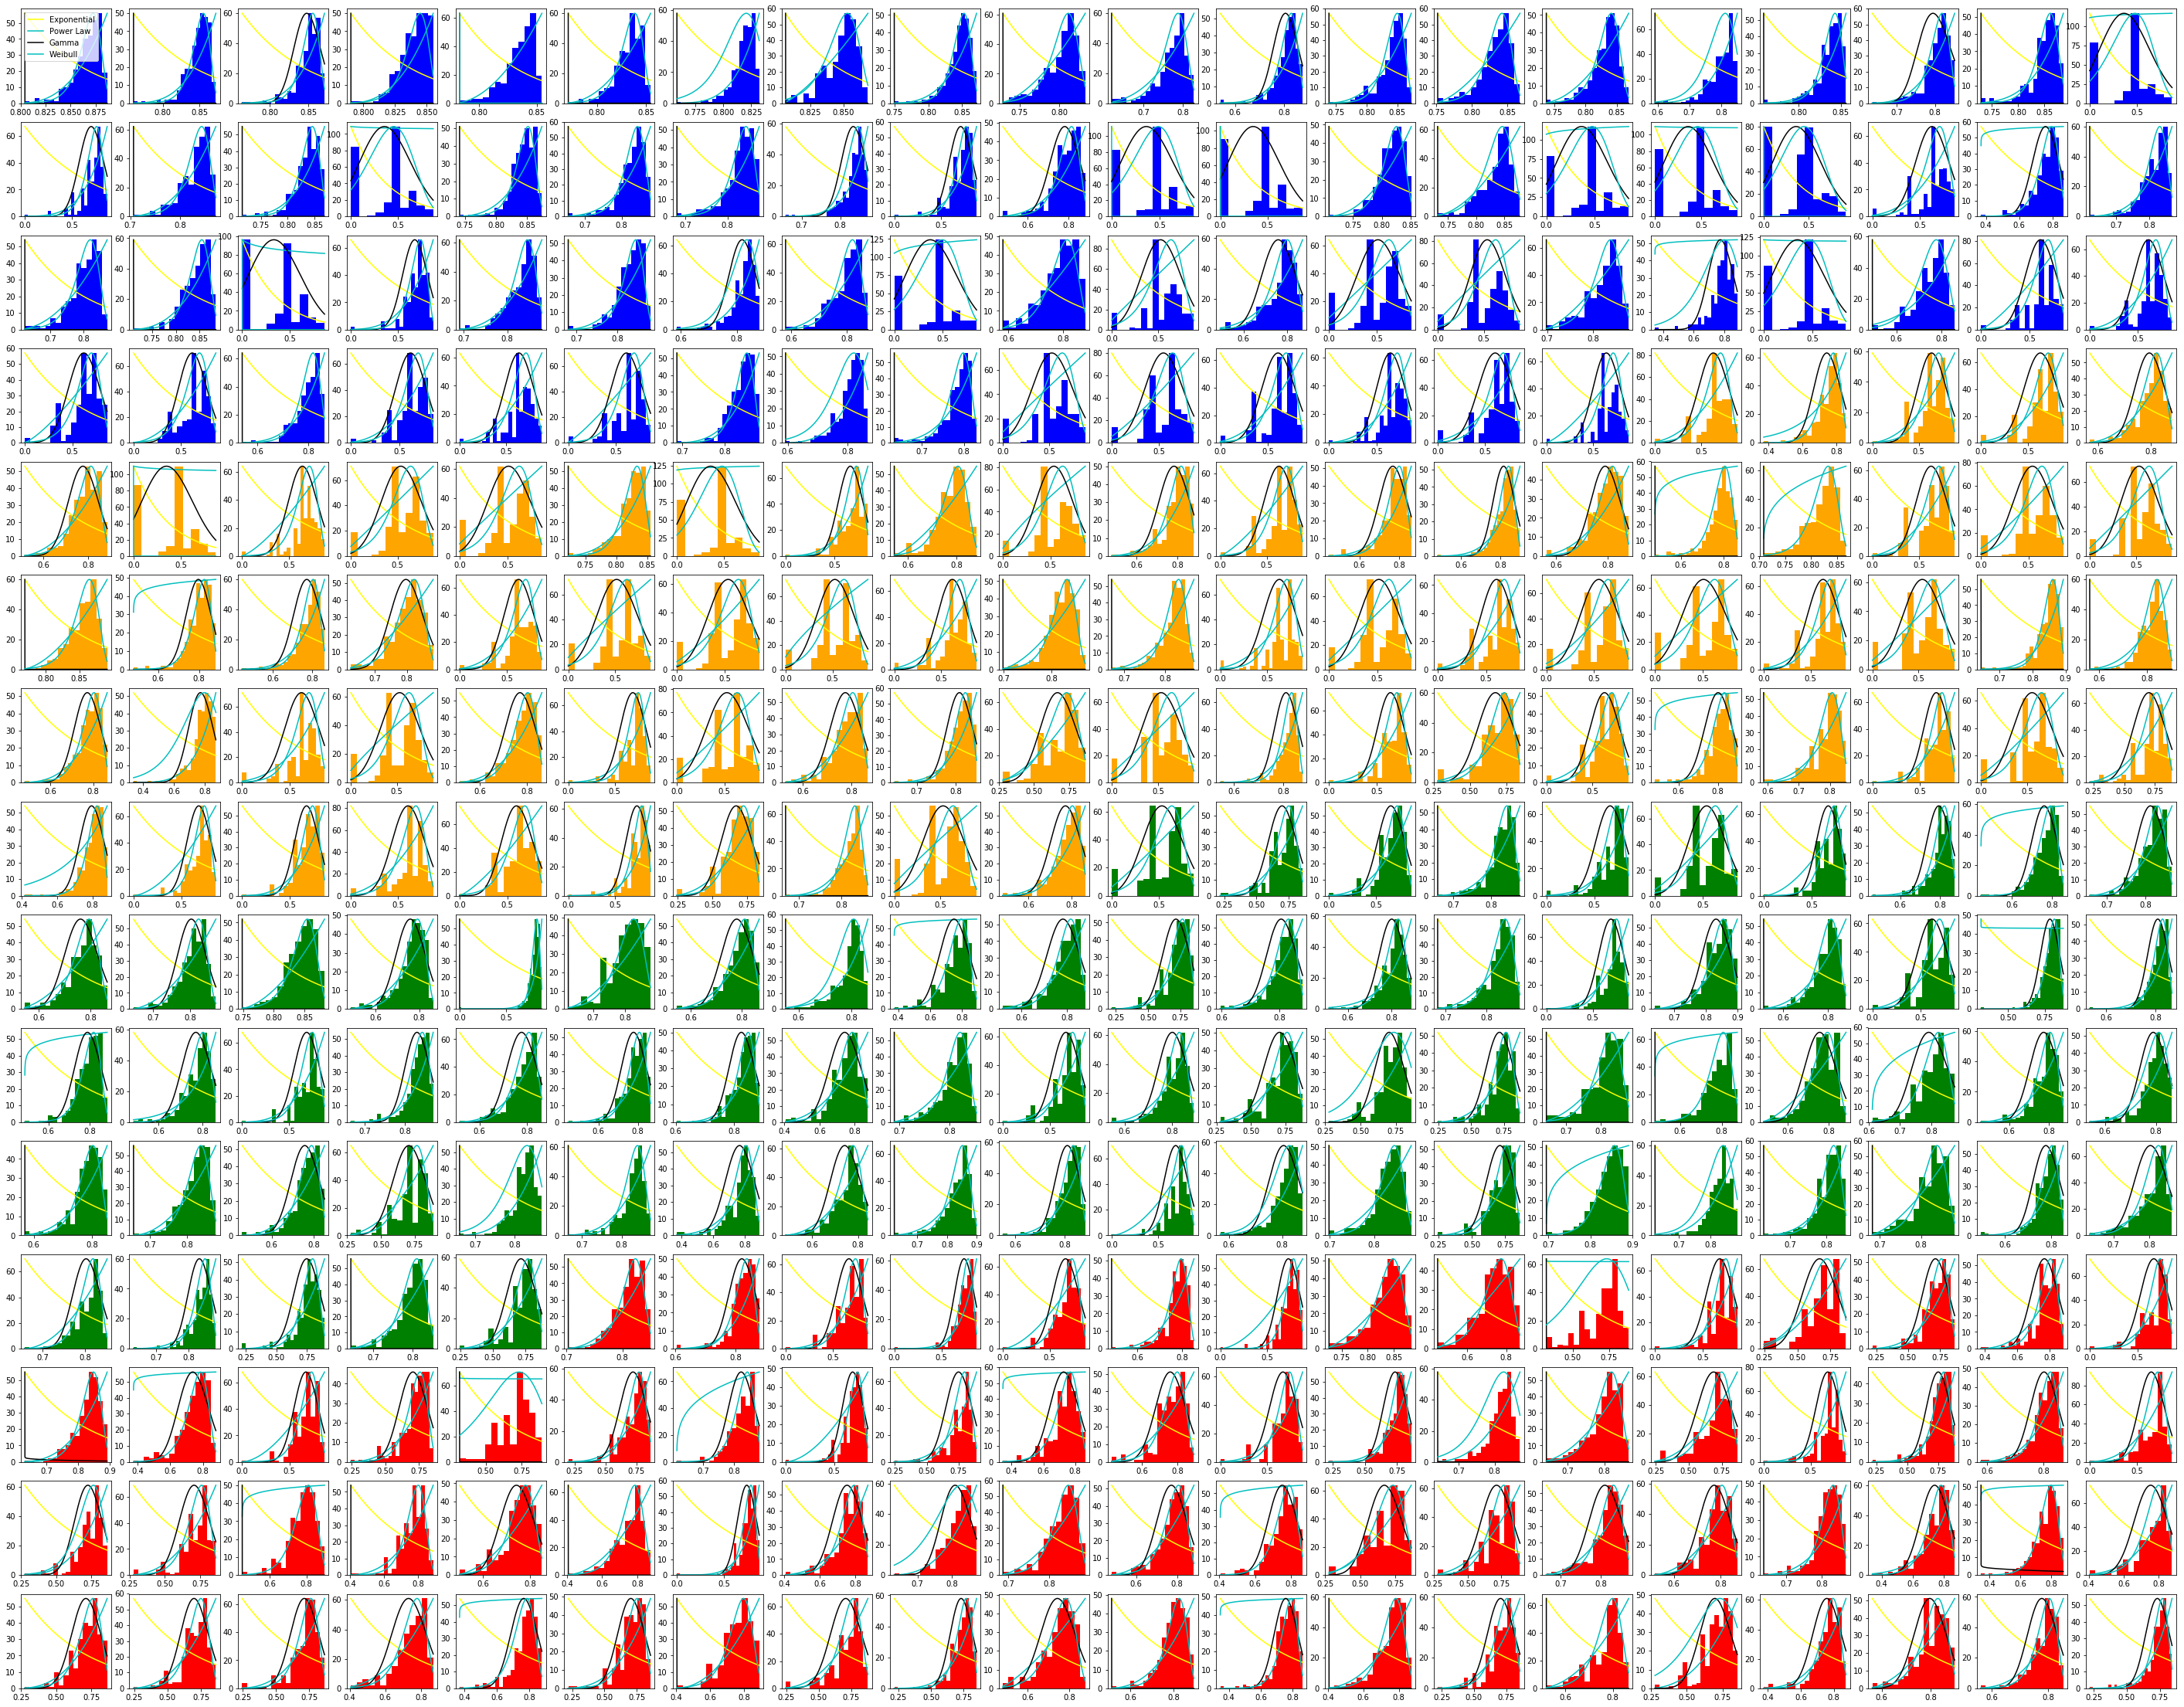

In [57]:
winnerPC=[]
fig=plt.figure(figsize=(50,40))
ax=[None]*len(pcoeffData)
fitValsPC=[None]*len(pcoeffData)
bicValsPC=[None]*len(pcoeffData)

for i in tqdm(range(len(pcoeffData))):
    ax[i]=fig.add_subplot(15,20,i+1)
    r=pcoeffData[i]
    # Find Frequencies and Bins
    bin_heights, bin_borders = np.histogram(r, bins='auto')
    bin_widths = np.diff(bin_borders)
    bin_centers = bin_borders[:-1] + bin_widths / 2

    #Fit Values:
#     LN, loc, scale = lognorm.fit(r, floc=0)
    E = expon.fit(r)
    PL = powerlaw.fit(r)
    WB = weibull_min.fit(r)
    G = gamma.fit(r)

    #Log Likelihood:
    llG = np.sum(gamma.logpdf(r, G[0], loc=G[1], scale=G[2]) ) 
    llE = np.sum(expon.logpdf(r, E[0], E[1]))
    llPL = np.sum(powerlaw.logpdf(r, PL[0], PL[1], PL[2]) ) 
#     llLM = np.sum(lognorm.logpdf(r, LN, loc=loc, scale=scale) ) 
    llWB = np.sum(weibull_min.logpdf(r, WB[0],WB[1],WB[2]) ) 

    #BIC:
    # BIC = -2 * LL + log(N) * k

    bicG = -2* llG + len(G)*np.log(len(r))
    bicE = -2* llE + len(E)*np.log(len(r))
    bicPL = -2* llPL + len([llPL])*np.log(len(r))
#     bicLM = -2* llLM + len([llLM])*np.log(len(r[0]))
    bicWB = -2* llWB + len(WB)*np.log(len(r))

    #Find length of x
    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

    #Plot Histogram
    if i < 75:
        color='b'
    elif i >=75 and i < 150:
        color = 'orange'
    elif i >=150 and i < 225:
        color = 'g'
    else:
        color = 'r'
    plt.bar(bin_centers, bin_heights, width=bin_widths,color=color)

    # Probability Density Function 
#     pdfLog = lognorm.pdf(x_interval_for_fit, LN, scale=scale)
    pdfExp = expon.pdf(x_interval_for_fit, *E)
    pdfPwl = powerlaw.pdf(x_interval_for_fit,*PL)
    pdfGam = gamma.pdf(x_interval_for_fit,*G)
    pdfWB = weibull_min.pdf(x_interval_for_fit,*WB)

    #Renormalise scale:
#     pdfLog=scaleData(pdfLog,bin_heights)
    pdfExp=scaleData(pdfExp,bin_heights)
    pdfPwl=scaleData(pdfPwl,bin_heights)
    pdfGam=scaleData(pdfGam,bin_heights)
    pdfWB=scaleData(pdfWB,bin_heights)

    #Plot fit on histogram
#     plt.plot(x_interval_for_fit, pdfLog, 'm',label='Log Norm')
    plt.plot(x_interval_for_fit, pdfExp, 'yellow',label='Exponential')
    plt.plot(x_interval_for_fit, pdfPwl, 'c',label='Power Law')
    plt.plot(x_interval_for_fit, pdfGam, 'k',label='Gamma')
    plt.plot(x_interval_for_fit, pdfWB, 'c',label='Weibull')
    if i == 0:
        plt.legend(loc='best')

#     print(f'Gamma BIC: {bicG}')
#     print(f'Exponential BIC: {bicE}')
#     print(f'Power Law BIC: {bicPL}')
#     print(f'Log Normal BIC: {bicLM}')

    if bicG < bicE and bicG < bicWB: #and bicG < bicLM:
        winnerPC.append('Gamma')
    elif bicE < bicG and bicE < bicWB: #and bicE < bicLM:
        winnerPC.append('Exponential')
    elif bicWB < bicG and bicWB < bicE:# and bicWB < bicLM:
        winnerPC.append('Weibull') 
    elif bicPL < bicG and bicPL < bicE and bicPL < bicWB:
        winner.append('Power Law')  
        
    bicValsPC[i]={'Exponential':bicE,'Gamma':bicG,'Power Law':bicPL,'Weibull':bicWB}
    fitValsPC[i]={'Exponential':E,'Gamma':G,'Power Law':PL,'Weibull':WB}
    
plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/BA Networks Curve Fitting Histograms PCOEFF sorted by Accuracy.png',format='png',dpi=300)

### BW Centrality

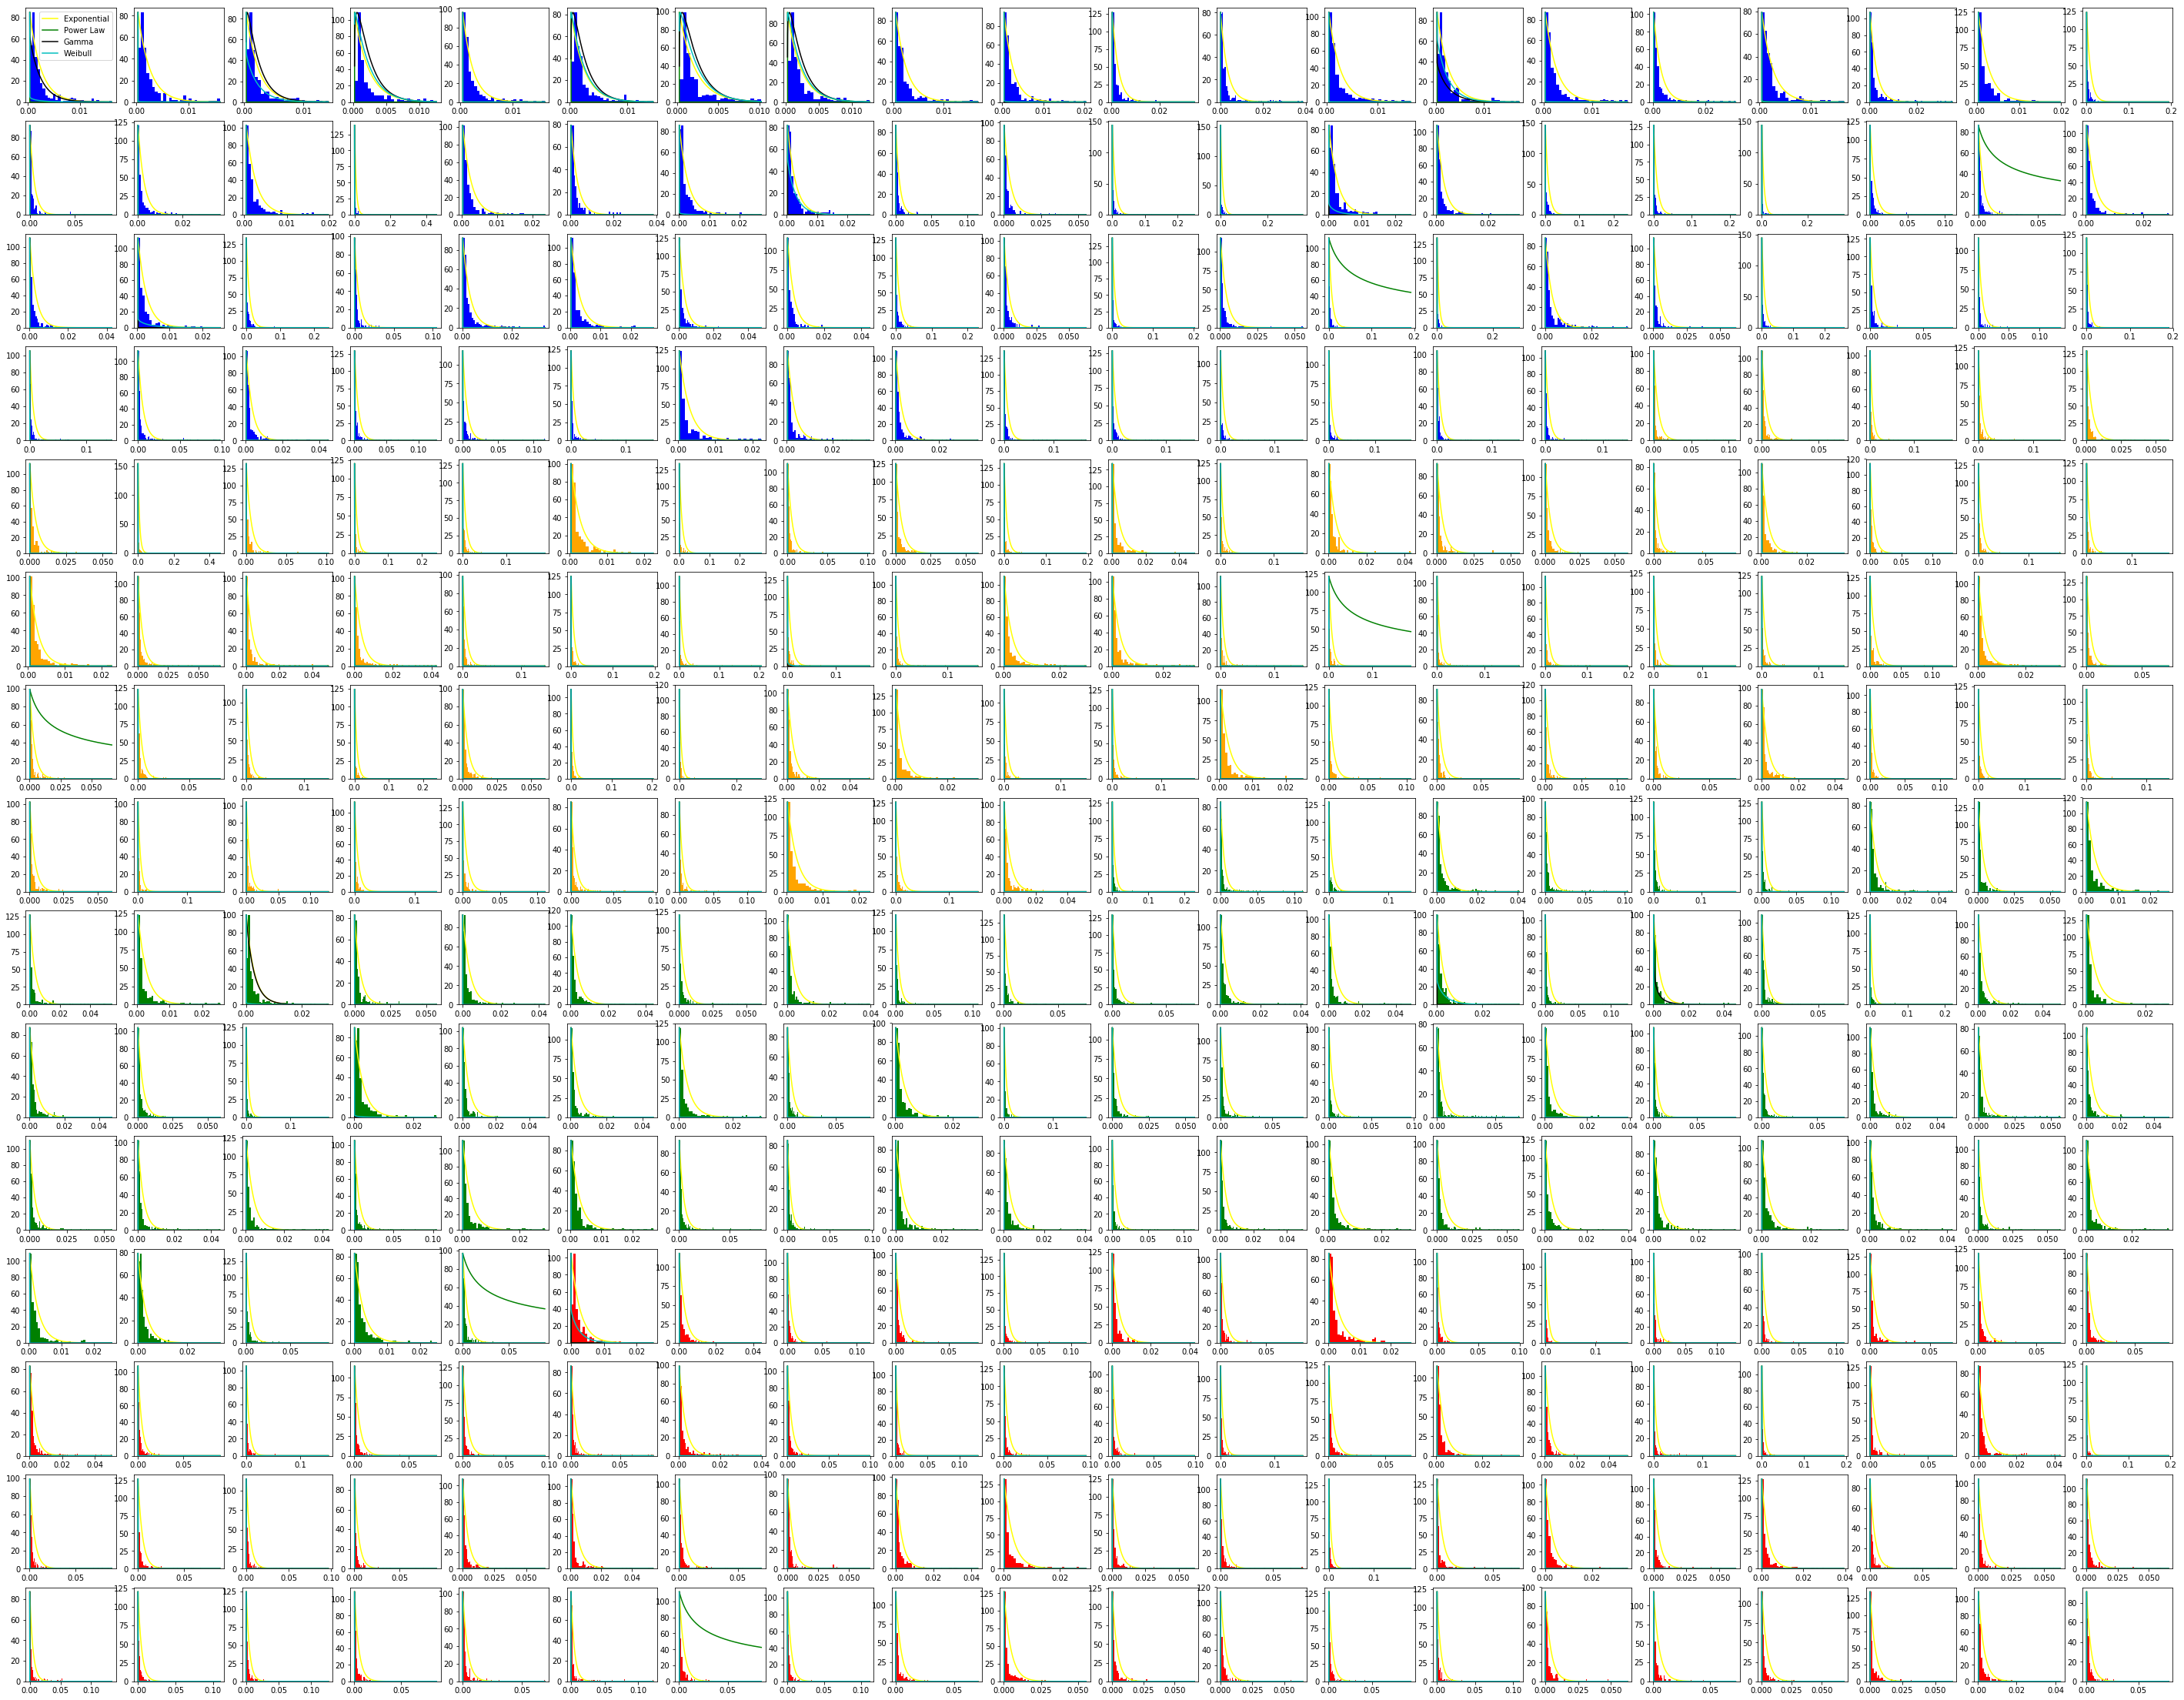

In [62]:
winnerBC=[]
fig=plt.figure(figsize=(50,40))
ax=[None]*len(bcData)
fitValsBC=[None]*len(bcData)
bicValsBC=[None]*len(bcData)

for i in tqdm(range(len(bcData))):
    ax[i]=fig.add_subplot(15,20,i+1)
    r=bcData[i]
    # Find Frequencies and Bins
    bin_heights, bin_borders = np.histogram(r, bins='auto')
    bin_widths = np.diff(bin_borders)
    bin_centers = bin_borders[:-1] + bin_widths / 2

    #Fit Values:
#     LN, loc, scale = lognorm.fit(r, floc=0)
    E = expon.fit(r)
    PL = powerlaw.fit(r)
    WB = weibull_min.fit(r)
    G = gamma.fit(r)

    #Negative Log Likelihood:
    llG = np.sum(gamma.logpdf(r, G[0], loc=G[1], scale=G[2]) ) 
    llE = np.sum(expon.logpdf(r, E[0], E[1]))
    llPL = np.sum(powerlaw.logpdf(r, PL[0], PL[1], PL[2]) ) 
#     llLM = np.sum(lognorm.logpdf(r, LN, loc=loc, scale=scale) ) 
    llWB = np.sum(weibull_min.logpdf(r, WB[0],WB[1],WB[2]) ) 

    #BIC:
    # BIC = -2 * LL + log(N) * k

    bicG = -2* llG + len(G)*np.log(len(r))
    bicE = -2* llE + len(E)*np.log(len(r))
    bicPL = -2* llPL + len([llPL])*np.log(len(r))
#     bicLM = -2* llLM + len([LN])*np.log(len(r[0]))
    bicWB = -2* llWB + len(WB)*np.log(len(r))

    #Find length of x
    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

    #Plot Histogram
    if i < 75:
        color='b'
    elif i >=75 and i < 150:
        color = 'orange'
    elif i >=150 and i < 225:
        color = 'g'
    else:
        color = 'r'
    plt.bar(bin_centers, bin_heights, width=bin_widths,color=color)

    # Probability Density Function 
#     pdfLog = lognorm.pdf(x_interval_for_fit, LN, scale=scale)
    pdfExp = expon.pdf(x_interval_for_fit, *E)
    pdfPwl = powerlaw.pdf(x_interval_for_fit,*PL)
    pdfGam = gamma.pdf(x_interval_for_fit,*G)
    pdfWB = weibull_min.pdf(x_interval_for_fit,*WB)

    #Renormalise scale:
#     pdfLog=scaleData(pdfLog,bin_heights)
    pdfExp=scaleData(pdfExp,bin_heights)
    pdfPwl=scaleData(pdfPwl,bin_heights)
    pdfGam=scaleData(pdfGam,bin_heights)
    pdfWB=scaleData(pdfWB,bin_heights)

    #Plot fit on histogram
#     plt.plot(x_interval_for_fit, pdfLog, 'm',label='Log Norm')
    plt.plot(x_interval_for_fit, pdfExp, 'yellow',label='Exponential')
    plt.plot(x_interval_for_fit, pdfPwl, 'g',label='Power Law')
    plt.plot(x_interval_for_fit, pdfGam, 'k',label='Gamma')
    plt.plot(x_interval_for_fit, pdfWB, 'c',label='Weibull')
    if i == 0:
        plt.legend(loc='best')

#     print(f'Gamma BIC: {bicG}')
#     print(f'Exponential BIC: {bicE}')
#     print(f'Power Law BIC: {bicPL}')
#     print(f'Log Normal BIC: {bicLM}')

    if bicG < bicE and bicG < bicWB: #and bicG < bicLM:
        winnerBC.append('Gamma')
    elif bicE < bicG and bicE < bicWB: #and bicE < bicLM:
        winnerBC.append('Exponential')
    elif bicWB < bicG and bicWB < bicE: #and bicWB < bicLM:
        winnerBC.append('Weibull') 
    elif bicPL < bicG and bicPL < bicE and bicPL < bicWB:
        winnerBC.append('Power Law')  

    bicValsBC[i]={'Exponential':bicE,'Gamma':bicG,'Weibull':bicWB,'Power Law':bicPL}
    fitValsBC[i]={'Exponential':E,'Gamma':G,'Weibull':WB,'Power Law':PL}

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/BA Networks Centrality Curve Fitting Histograms sorted by Accuracy.png',format='png',dpi=300)

In [63]:
#equal bins

#sort asn_acc:
ba_sorted=np.sort(ba_acc)
ba_idx=np.argsort(ba_acc)

sorted_winner=[]
for idx in ba_idx:
    sorted_winner.append(winner[idx])
    
sorted_winnerPC=[]
for idx in ba_idx:
    sorted_winnerPC.append(winnerPC[idx])
    
    
sorted_winnerBC=[]
for idx in ba_idx:
    sorted_winnerBC.append(winnerBC[idx])

/suphys/aloe8475/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/suphys/aloe8475/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/suphys/aloe8475/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warni

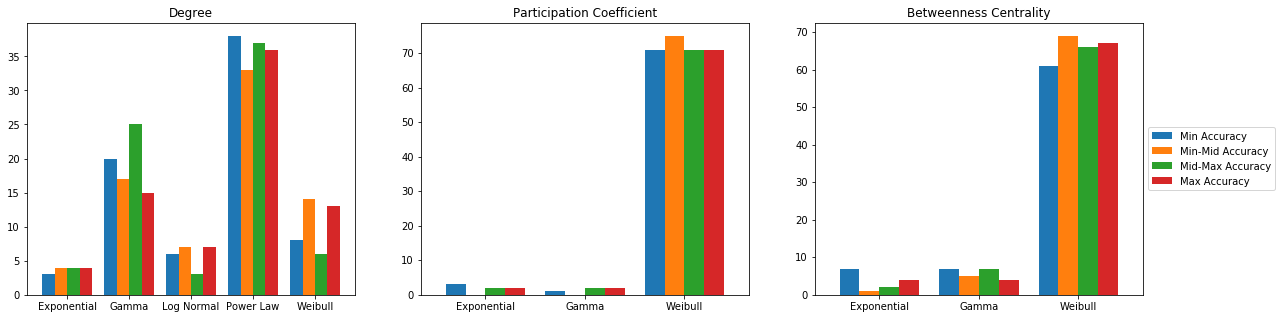

In [64]:
# ax=[None]*4
# ax[0]=fig.add_subplot(2,2,1)
# ax[0].set_title('All networks')
# bins = []
num_bins = 4
data_points_per_bin = len(sorted_winner) // num_bins
binnedACC = [sorted_winner[_ * data_points_per_bin: (_+1)*data_points_per_bin] for _ in range(num_bins)]# ax[1]=fig.add_subplot(2,2,3)
# h=plt.hist(np.sort(binnedACC).tolist(),bins=np.arange(4)-0.5)

# plt.legend(h[-1],['Min Accuracy','Min-Mid Accuracy','Mid-Max Accuracy','Max Accuracy'])
num_bins = 4
data_points_per_bin = len(sorted_winnerPC) // num_bins
binnedACC_PC = [sorted_winnerPC[_ * data_points_per_bin: (_+1)*data_points_per_bin] for _ in range(num_bins)]# ax[1]=fig.add_subplot(2,2,3)

num_bins = 4
data_points_per_bin = len(sorted_winnerBC) // num_bins
binnedACC_BC = [sorted_winnerBC[_ * data_points_per_bin: (_+1)*data_points_per_bin] for _ in range(num_bins)]# ax[1]=fig.add_subplot(2,2,3)


fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20,5))

new_df=pd.DataFrame()
labels=['Min Accuracy','Min-Mid Accuracy','Mid-Max Accuracy','Max Accuracy']
for i in range(len(binnedACC)):
    letter_counts = Counter(binnedACC[i])
    df = pandas.DataFrame.from_dict(letter_counts, orient='index')
    new_df=pd.concat([new_df, df], axis=1)
    
new_df.columns=[labels[i] for i,_ in enumerate(new_df.columns)]#rename columns
new_df.plot(ax=axes[0],kind='bar',rot=0,width=0.8,title='Degree',legend=False)
# plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/All Networks Degree Curve Fitting Binned by Accuracy.png',format='png',dpi=300)

new_df=pd.DataFrame()
labels=['Min Accuracy','Min-Mid Accuracy','Mid-Max Accuracy','Max Accuracy']
for i in range(len(binnedACC_PC)):
    letter_counts = Counter(binnedACC_PC[i])
    df = pandas.DataFrame.from_dict(letter_counts, orient='index')
    new_df=pd.concat([new_df, df], axis=1)
    
new_df.columns=[labels[i] for i,_ in enumerate(new_df.columns)]#rename columns
new_df.plot(ax=axes[1],kind='bar',rot=0,width=0.8,title='Participation Coefficient',legend=False)


new_df=pd.DataFrame()
labels=['Min Accuracy','Min-Mid Accuracy','Mid-Max Accuracy','Max Accuracy']
for i in range(len(binnedACC_BC)):
    letter_counts = Counter(binnedACC_BC[i])
    df = pandas.DataFrame.from_dict(letter_counts, orient='index')
    new_df=pd.concat([new_df, df], axis=1)
    
new_df.columns=[labels[i] for i,_ in enumerate(new_df.columns)]#rename columns
new_df.plot(ax=axes[2],kind='bar',rot=0,width=0.8,title='Betweenness Centrality').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))


plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/BA Networks Degree_PCoeff_Centrality Curve Fitting Binned by Accuracy.svg',format='svg',dpi=300)
